# Importing necessary things

In [1]:
import pandas as pd
import numpy as np
import sklearn

import sklearn.metrics as metrics
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, RegexpTokenizer, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

from collections import Counter

import re
from datetime import datetime

import pickle

import string

==================================================================================================================

# Retrieving lists and making Dataframes

In [2]:
# Retrieving the lists.

import bz2

def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = pickle.load(data)
    return data

# Seeing if everything transferred properly

reviewlistglobal = decompress_pickle('compressedlistreview.pbz2')
reviewlistsea = decompress_pickle('compressedlistreview2.pbz2')
reviewlistapple = decompress_pickle('compressedlistreviewapple.pbz2')

print(len(reviewlistglobal))
print(len(reviewlistsea))
print(len(reviewlistapple))

6533
72231
1318


In [3]:
dfglobal = pd.DataFrame(reviewlistglobal)
dfglobal.head()

,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,appId
0,Game full of bots on auto-attack who kill all ...,1,0,1.2.6,2021-01-07 18:23:03,None,com.gravity.romNAg
1,fun gamee,5,0,1.2.6,2021-01-07 14:14:55,None,com.gravity.romNAg
2,Very nostalgic. They did an excellent job with...,4,0,1.2.6,2021-01-07 00:05:07,None,com.gravity.romNAg
3,"Good graphics cute characters, fun to find and...",5,0,None,2021-01-06 05:34:03,None,com.gravity.romNAg
4,im new very nice game,5,0,1.2.6,2021-01-06 04:24:53,None,com.gravity.romNAg


In [4]:
dfsea = pd.DataFrame(reviewlistsea)
dfsea.head()

,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,appId
0,Trying to install the game but when extracting...,1,0,None,2021-01-07 21:54:59,None,com.gravity.romg
1,Lagnarok M: Eternal Bug ..... please fix the g...,1,0,1.0.35,2021-01-07 21:07:19,None,com.gravity.romg
2,a trash is always a trash lot of bugs and chea...,1,0,1.0.35,2021-01-07 20:17:35,None,com.gravity.romg
3,B Aja,3,1,1.0.35,2021-01-07 13:27:04,None,com.gravity.romg
4,Ragnarok Eternal Lag,2,0,1.0.35,2021-01-07 10:44:20,None,com.gravity.romg


In [5]:
dfapple = pd.DataFrame(reviewlistapple)
dfapple.head()

,isEdited,date,rating,review,title,userName
0,False,2020-02-25 02:00:45,5,I played Ragnarok Online for over a decade sta...,The best version of Ragnarok on mobile,Don-Karnage
1,False,2020-06-22 07:12:05,4,"Full disclosure, I’ve played this game since l...","A fantastic MMORPG, but with its fair share of...",SexGodCrusher
2,False,2019-11-26 06:35:01,4,This game could be amazing. I love it and don’...,I love this game but developers ignore complaints,Kwestland
3,False,2019-10-25 23:14:50,5,"As you would know if you read the title, I’m a...","I am not being paid, nor am I a robot",lindaxw
4,False,2020-11-27 01:30:44,1,First I’d like to point out your own website p...,Update broke the game,PatfromPittsburgh


In [6]:
# Renaming columns to match google play store columns for ease of typing later.

dfapple = dfapple.rename(columns={'date' : 'at', 'rating' : 'score', 'review' : 'content'})
dfapple.head()

,isEdited,at,score,content,title,userName
0,False,2020-02-25 02:00:45,5,I played Ragnarok Online for over a decade sta...,The best version of Ragnarok on mobile,Don-Karnage
1,False,2020-06-22 07:12:05,4,"Full disclosure, I’ve played this game since l...","A fantastic MMORPG, but with its fair share of...",SexGodCrusher
2,False,2019-11-26 06:35:01,4,This game could be amazing. I love it and don’...,I love this game but developers ignore complaints,Kwestland
3,False,2019-10-25 23:14:50,5,"As you would know if you read the title, I’m a...","I am not being paid, nor am I a robot",lindaxw
4,False,2020-11-27 01:30:44,1,First I’d like to point out your own website p...,Update broke the game,PatfromPittsburgh


# Changing datatypes to correct datatypes.

In [7]:
#Changing datatype to correct datatype as they are all objects.

print(dfglobal.dtypes)
print('----------------')
print(dfsea.dtypes)
print('----------------')
print(dfapple.dtypes)

content                 object
score                   object
thumbsUpCount           object
reviewCreatedVersion    object
at                      object
replyContent            object
appId                   object
dtype: object
----------------
content                 object
score                   object
thumbsUpCount           object
reviewCreatedVersion    object
at                      object
replyContent            object
appId                   object
dtype: object
----------------
isEdited              bool
at          datetime64[ns]
score                int64
content             object
title               object
userName            object
dtype: object


In [8]:
dfglobal['content'] = dfglobal['content'].astype('string')
dfglobal['score'] = dfglobal['score'].astype('int')
dfglobal['thumbsUpCount'] = dfglobal['thumbsUpCount'].astype('int')
dfglobal['reviewCreatedVersion'] = dfglobal['reviewCreatedVersion'].astype('string')
dfglobal['at'] = dfglobal['at'].astype('string')
dfglobal['replyContent'] = dfglobal['replyContent'].astype('string')
dfglobal['appId'] = dfglobal['appId'].astype('string')

################################################

dfsea['content'] = dfsea['content'].astype('string')
dfsea['score'] = dfsea['score'].astype('int')
dfsea['thumbsUpCount'] = dfsea['thumbsUpCount'].astype('int')
dfsea['reviewCreatedVersion'] = dfsea['reviewCreatedVersion'].astype('string')
dfsea['at'] = dfsea['at'].astype('string')
dfsea['replyContent'] = dfsea['replyContent'].astype('string')
dfsea['appId'] = dfsea['appId'].astype('string')

################################################

dfapple['at'] = dfapple['at'].astype('string')
dfapple['content'] = dfapple['content'].astype('string')

In [9]:
# checking for null values.

print(dfglobal.isna().sum())
print('-------------------------')
print(dfsea.isna().sum())
print('-------------------------')
print(dfapple.isna().sum())

content                 0
score                   0
thumbsUpCount           0
reviewCreatedVersion    0
at                      0
replyContent            0
appId                   0
dtype: int64
-------------------------
content                 0
score                   0
thumbsUpCount           0
reviewCreatedVersion    0
at                      0
replyContent            0
appId                   0
dtype: int64
-------------------------
isEdited    0
at          0
score       0
content     0
title       0
userName    0
dtype: int64


==================================================================================================================

# EDA

In [10]:
# Looking at distribution of ratings in both global and sea

print(dfglobal['score'].value_counts())
print('---------------------')
print(dfsea['score'].value_counts())
print('---------------------')
print(dfapple['score'].value_counts())

5    3133
1    1771
4     655
3     567
2     407
Name: score, dtype: int64
---------------------
5    33343
1    27554
4     4865
3     3851
2     2618
Name: score, dtype: int64
---------------------
1    541
5    454
4    119
3    118
2     86
Name: score, dtype: int64


In [11]:
scorecountglobal = Counter(dfglobal['score'])
scorecountsea = Counter(dfsea['score'])
scorecountapple = Counter(dfapple['score'])

print(scorecountglobal.most_common(5))
print('-----------------------------------------')
print(scorecountsea.most_common(5))
print('-----------------------------------------')
print(scorecountapple.most_common(5))

[(5, 3133), (1, 1771), (4, 655), (3, 567), (2, 407)]
-----------------------------------------
[(5, 33343), (1, 27554), (4, 4865), (3, 3851), (2, 2618)]
-----------------------------------------
[(1, 541), (5, 454), (4, 119), (3, 118), (2, 86)]


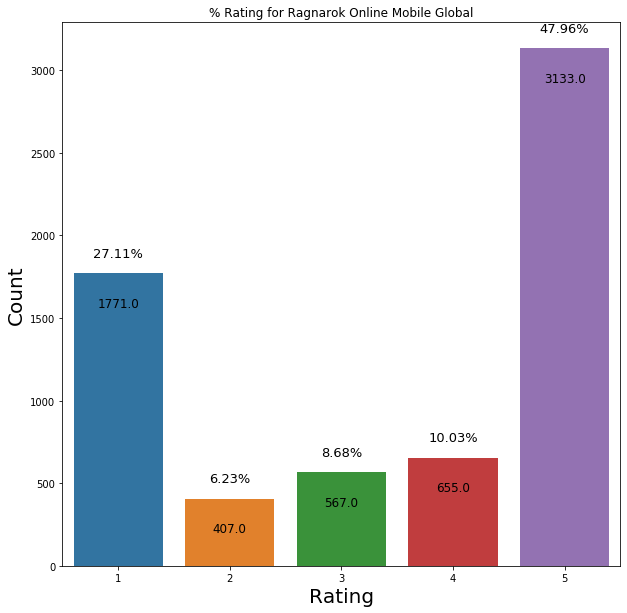

In [12]:
# Plotting distribution of ratings out of all the reviews
# Interestingly, it is very similar to overall rating distribution across all top mobile games.


xaxis = [val[0] for val in scorecountglobal.most_common(5)]
yaxis = [val[1] for val in scorecountglobal.most_common(5)]

plt.figure(figsize=(10,10))
ax = sns.barplot(xaxis, yaxis)

plt.title('% Rating for Ragnarok Online Mobile Global')
plt.ylabel('Count', fontsize = 20)
plt.xlabel('Rating', fontsize = 20)


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')
        
for p in ax.patches:
             ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, -30),
                 textcoords='offset points')

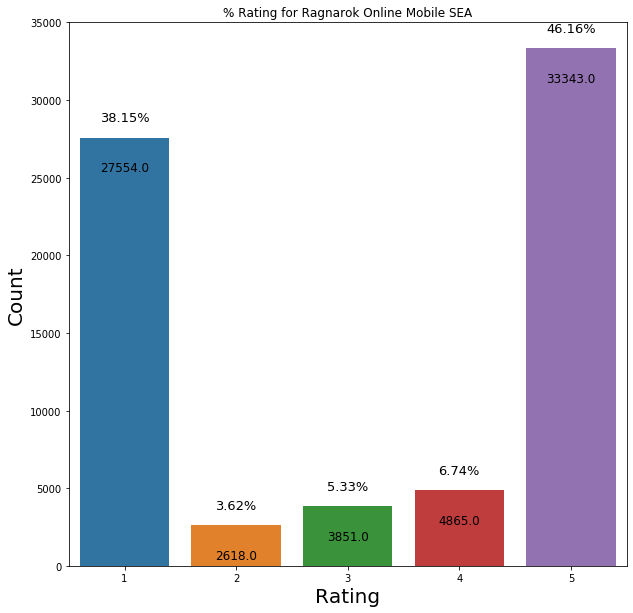

In [13]:
xaxis = [val[0] for val in scorecountsea.most_common(5)]
yaxis = [val[1] for val in scorecountsea.most_common(5)]

plt.figure(figsize=(10,10))
ax = sns.barplot(xaxis, yaxis)

plt.title('% Rating for Ragnarok Online Mobile SEA')
plt.ylabel('Count', fontsize = 20)
plt.xlabel('Rating', fontsize = 20)


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')
        
for p in ax.patches:
             ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, -30),
                 textcoords='offset points')

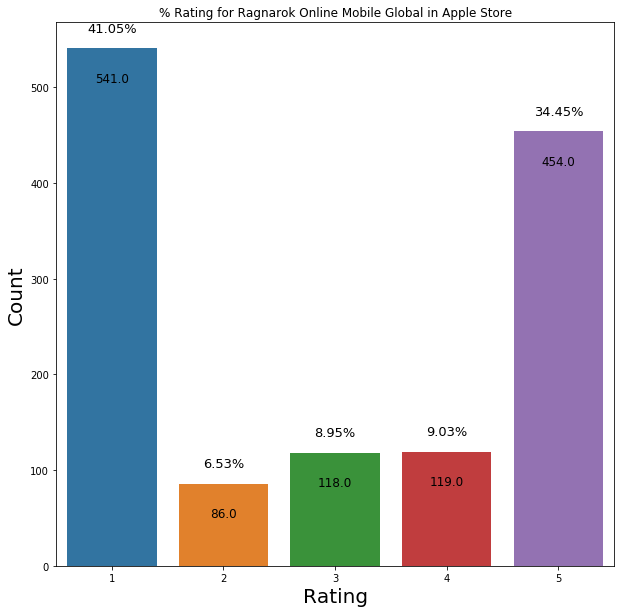

In [14]:
xaxis = [val[0] for val in scorecountapple.most_common(5)]
yaxis = [val[1] for val in scorecountapple.most_common(5)]

plt.figure(figsize=(10,10))
ax = sns.barplot(xaxis, yaxis)

plt.title('% Rating for Ragnarok Online Mobile Global in Apple Store')
plt.ylabel('Count', fontsize = 20)
plt.xlabel('Rating', fontsize = 20)


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')
        
for p in ax.patches:
             ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, -30),
                 textcoords='offset points')

In [15]:
# Interestingly despite following the same-ish timeline and being on the same page,
# the listed reviews created versions are different.
# Of course, this is not applicable to the apple reviews.

print(dfglobal['reviewCreatedVersion'].value_counts())
print('---------------------')
print(dfsea['reviewCreatedVersion'].value_counts())

1.0.1    4426
None     1187
1.0.7     216
1.1.3     147
1.0.5     147
1.1.0     133
1.2.6      91
1.2.0      74
1.2.2      61
1.2.4      51
Name: reviewCreatedVersion, dtype: Int64
---------------------
1.0.5     25364
None      13897
1.0.9     11759
1.0.8     11220
1.0.25     2392
1.0.27     2134
1.0.10     1747
1.0.33     1489
1.0.30     1003
1.0.35      771
1.0.3       453
1.0.32        2
Name: reviewCreatedVersion, dtype: Int64


### Datetime cleaning

In [16]:
# Cutting off the hours/mins/secs

dfglobal['at'] = dfglobal['at'].str[0:10]
dfsea['at'] = dfsea['at'].str[0:10]
dfapple['at'] = dfapple['at'].str[0:10]

print(dfglobal['at'].value_counts())
print('---------------------')
print(dfsea['at'].value_counts())
print('---------------------')
print(dfapple['at'].value_counts())

2019-01-09    715
2019-01-10    408
2019-01-11    264
2019-01-12    197
2019-01-08    167
             ... 
2020-06-19      1
2019-09-19      1
2020-05-14      1
2019-08-15      1
2020-11-09      1
Name: at, Length: 634, dtype: Int64
---------------------
2018-10-31    6033
2018-11-01    2683
2019-01-14    2526
2018-10-30    2194
2019-07-28    2047
              ... 
2021-01-04       7
2020-12-21       6
2020-09-21       6
2020-12-27       6
2020-12-26       5
Name: at, Length: 801, dtype: Int64
---------------------
2019-01-09    171
2019-01-10     76
2019-01-08     73
2019-01-11     57
2019-01-13     45
             ... 
2020-09-04      1
2019-07-31      1
2019-06-06      1
2020-03-31      1
2020-08-27      1
Name: at, Length: 394, dtype: Int64


In [18]:
# Getting only the month 

dfglobal['month'] = dfglobal['at'].str[5:7]
dfsea['month'] = dfsea['at'].str[5:7]
dfapple['month'] = dfapple['at'].str[5:7]

In [19]:
# Converting to workable format

dfglobal['at'] = pd.to_datetime(dfglobal['at'], format='%Y-%m-%d')
dfsea['at'] = pd.to_datetime(dfsea['at'], format='%Y-%m-%d')
dfapple['at'] = pd.to_datetime(dfapple['at'], format='%Y-%m-%d')

In [20]:
reviewglobaltimecounts = dfglobal['at'].value_counts().reset_index(name='counts')
reviewglobaltimecounts.columns = ['date', 'counts']

reviewseatimecounts = dfsea['at'].value_counts().reset_index(name='counts')
reviewseatimecounts.columns = ['date', 'counts']

reviewappletimecounts = dfapple['at'].value_counts().reset_index(name='counts')
reviewappletimecounts.columns = ['date', 'counts']

print(reviewglobaltimecounts)
print('----------------------')
print(reviewseatimecounts)
print('----------------------')
print(reviewappletimecounts)

          date  counts
0   2019-01-09     715
1   2019-01-10     408
2   2019-01-11     264
3   2019-01-12     197
4   2019-01-08     167
..         ...     ...
629 2019-11-07       1
630 2020-05-04       1
631 2019-07-17       1
632 2019-11-26       1
633 2020-11-30       1

[634 rows x 2 columns]
----------------------
          date  counts
0   2018-10-31    6033
1   2018-11-01    2683
2   2019-01-14    2526
3   2018-10-30    2194
4   2019-07-28    2047
..         ...     ...
796 2020-12-16       7
797 2020-12-21       6
798 2020-12-27       6
799 2020-09-21       6
800 2020-12-26       5

[801 rows x 2 columns]
----------------------
          date  counts
0   2019-01-09     171
1   2019-01-10      76
2   2019-01-08      73
3   2019-01-11      57
4   2019-01-13      45
..         ...     ...
389 2020-06-08       1
390 2020-06-18       1
391 2019-07-18       1
392 2020-03-22       1
393 2020-04-18       1

[394 rows x 2 columns]


In [21]:
# Sorting the dates in chronological order. This helps visualization.

reviewglobaltimecounts = reviewglobaltimecounts.sort_values(by='date')
reviewseatimecounts = reviewseatimecounts.sort_values(by='date')
reviewappletimecounts = reviewappletimecounts.sort_values(by='date')

reviewglobalmonthcount = dfglobal['month'].value_counts().reset_index(name='counts')
reviewglobalmonthcount.columns = ['month', 'counts']

reviewseamonthcount = dfsea['month'].value_counts().reset_index(name='counts')
reviewseamonthcount.columns = ['month', 'counts']

reviewapplemonthcount = dfapple['month'].value_counts().reset_index(name='counts')
reviewapplemonthcount.columns = ['month', 'counts']

print(reviewglobalmonthcount)
print('----------------------')
print(reviewseamonthcount)
print('----------------------')
print(reviewapplemonthcount)

   month  counts
0     01    3310
1     02     769
2     03     629
3     04     492
4     05     268
5     06     224
6     07     164
7     09     161
8     08     157
9     10     132
10    11     115
11    12     112
----------------------
   month  counts
0     11   18628
1     10   10670
2     01   10106
3     12    7765
4     07    6636
5     08    5302
6     02    3018
7     03    2638
8     04    2172
9     09    1974
10    06    1737
11    05    1585
----------------------
   month  counts
0     01     745
1     02     106
2     03      83
3     04      67
4     06      50
5     05      46
6     11      44
7     08      42
8     12      38
9     09      37
10    07      31
11    10      29


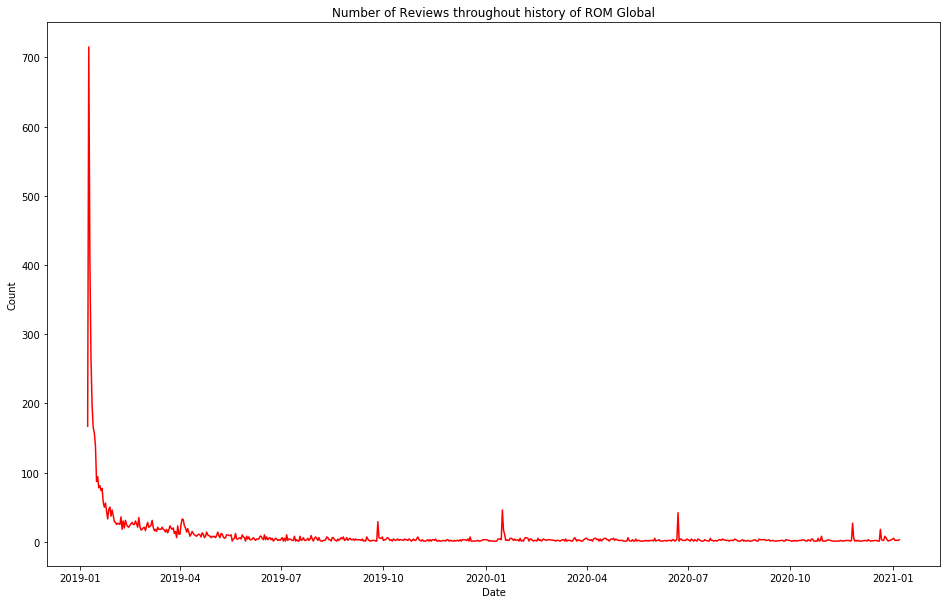

In [22]:
fig, ax = plt.subplots(figsize=(16, 10))

ax.plot(reviewglobaltimecounts['date'],
        reviewglobaltimecounts['counts'],
        color='red')

ax.set(xlabel="Date",
       ylabel="Count",
       title="Number of Reviews throughout history of ROM Global")

plt.show()

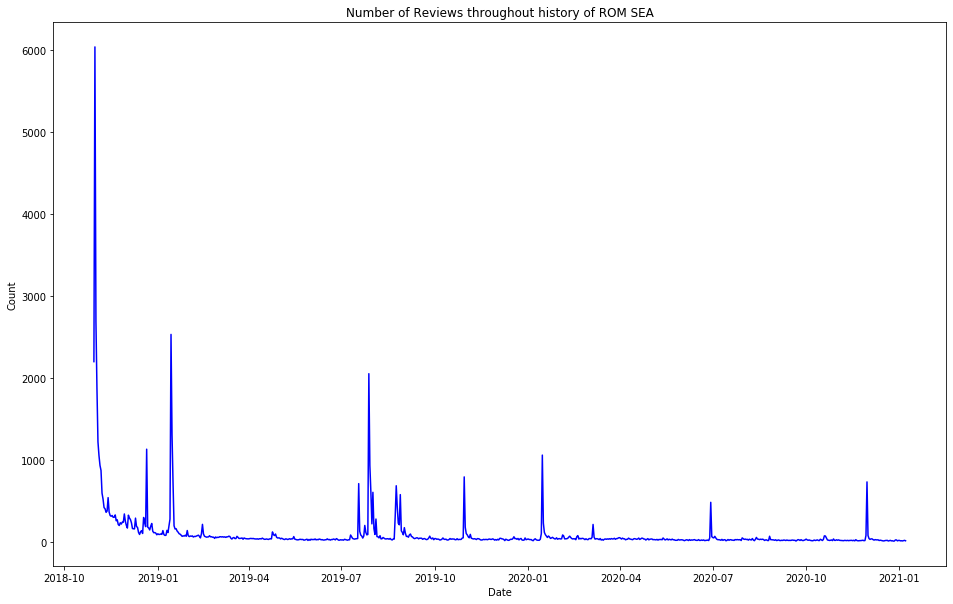

In [24]:
fig, ax = plt.subplots(figsize=(16, 10))

ax.plot(reviewseatimecounts['date'],
        reviewseatimecounts['counts'],
        color='blue')

ax.set(xlabel="Date",
       ylabel="Count",
       title="Number of Reviews throughout history of ROM SEA")

plt.show()

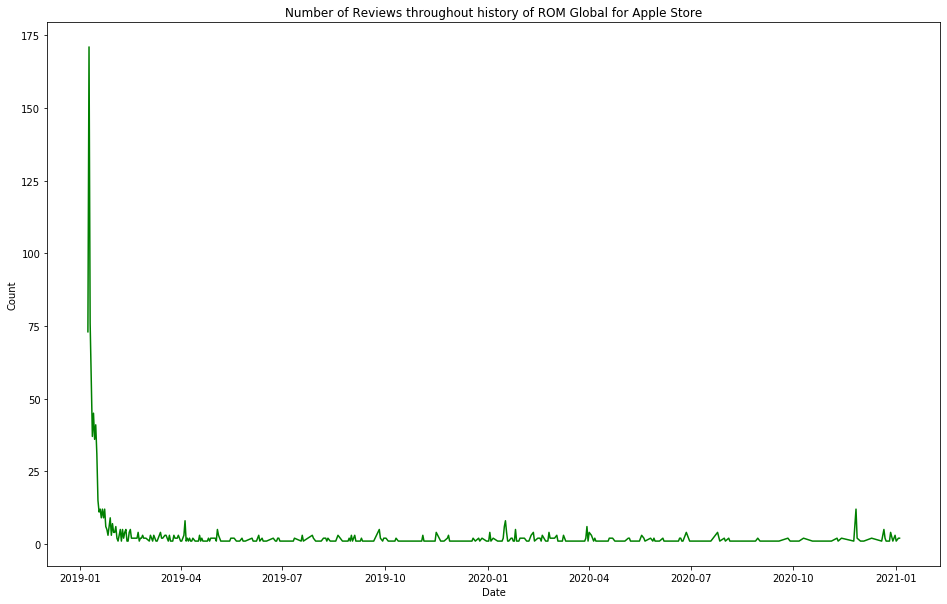

In [25]:
fig, ax = plt.subplots(figsize=(16, 10))

ax.plot(reviewappletimecounts['date'],
        reviewappletimecounts['counts'],
        color='green')

ax.set(xlabel="Date",
       ylabel="Count",
       title="Number of Reviews throughout history of ROM Global for Apple Store")

plt.show()

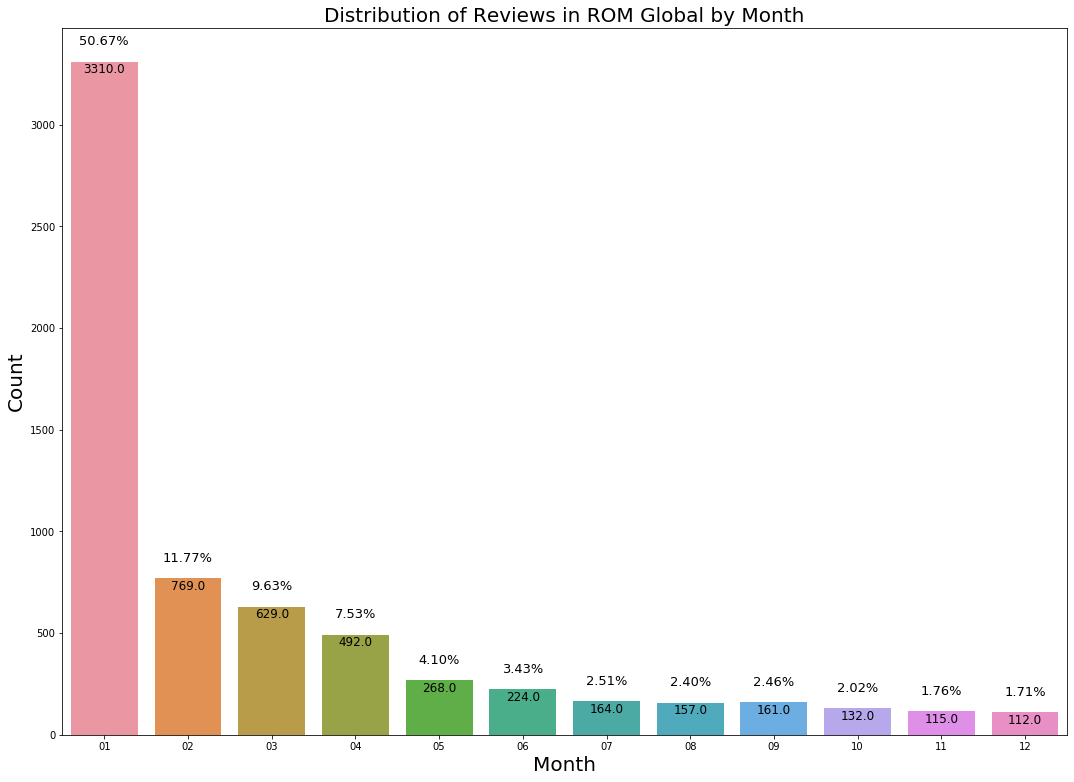

In [26]:
plt.figure(figsize=(18,13))
ax = sns.barplot(reviewglobalmonthcount['month'], reviewglobalmonthcount['counts'])

plt.title('Distribution of Reviews in ROM Global by Month', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.xlabel('Month', fontsize = 20)


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(reviewglobalmonthcount['counts']))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')
        
for p in ax.patches:
             ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, -8),
                 textcoords='offset points')

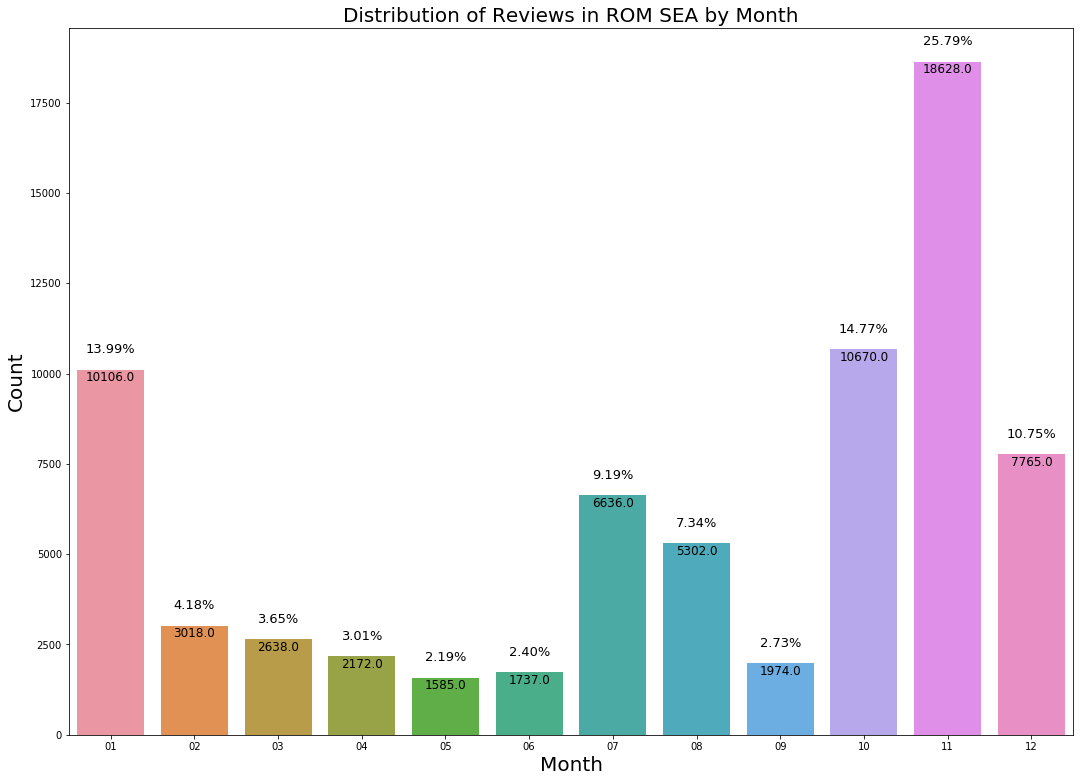

In [27]:
plt.figure(figsize=(18,13))
ax = sns.barplot(reviewseamonthcount['month'], reviewseamonthcount['counts'])

plt.title('Distribution of Reviews in ROM SEA by Month', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.xlabel('Month', fontsize = 20)


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(reviewseamonthcount['counts']))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')
        
for p in ax.patches:
             ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, -8),
                 textcoords='offset points')

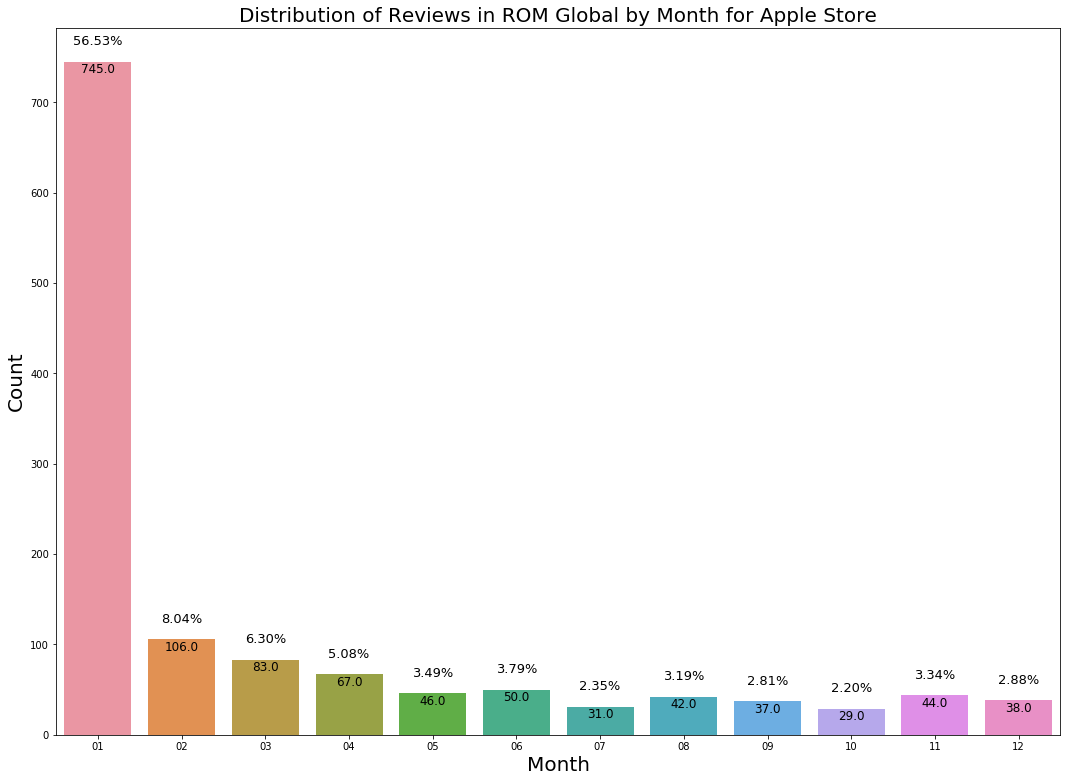

In [28]:
plt.figure(figsize=(18,13))
ax = sns.barplot(reviewapplemonthcount['month'], reviewapplemonthcount['counts'])

plt.title('Distribution of Reviews in ROM Global by Month for Apple Store', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.xlabel('Month', fontsize = 20)


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(reviewapplemonthcount['counts']))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')
        
for p in ax.patches:
             ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, -8),
                 textcoords='offset points')

## Meta Features

In [30]:
print(dfglobal['content'])
print('----------------------------------------------------------')
print(dfsea['content'])
print('----------------------------------------------------------')
print(dfapple['content'])

0       Game full of bots on auto-attack who kill all ...
1                                               fun gamee
2       Very nostalgic. They did an excellent job with...
3       Good graphics cute characters, fun to find and...
4                                   im new very nice game
                              ...                        
6528       the best gaming experience for a mobile mmorpg
6529                                  nice game, pls dont
6530    it let me download and install but will not le...
6531    Gravity❤❤❤ R.O.Mobile version 😍😍😍! So, excitin...
6532    I love the old game can't wait to fall in love...
Name: content, Length: 6533, dtype: string
----------------------------------------------------------
0        Trying to install the game but when extracting...
1        Lagnarok M: Eternal Bug ..... please fix the g...
2        a trash is always a trash lot of bugs and chea...
3                                                    B Aja
4                       

## Meta Features for ROM Global

In [31]:
dfglobal["numwords"] = dfglobal["content"].apply(lambda x: len(str(x).split()))

dfglobal["numuniquewords"] = dfglobal["content"].apply(lambda x: len(set(str(x).split())))

dfglobal["numchars"] = dfglobal["content"].apply(lambda x: len(str(x)))

dfglobal["numpuncts"] = dfglobal['content'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

dfglobal["numcapts"] = dfglobal["content"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

dfglobal["numtitles"] = dfglobal["content"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

dfglobal["meanwordlength"] = dfglobal["content"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


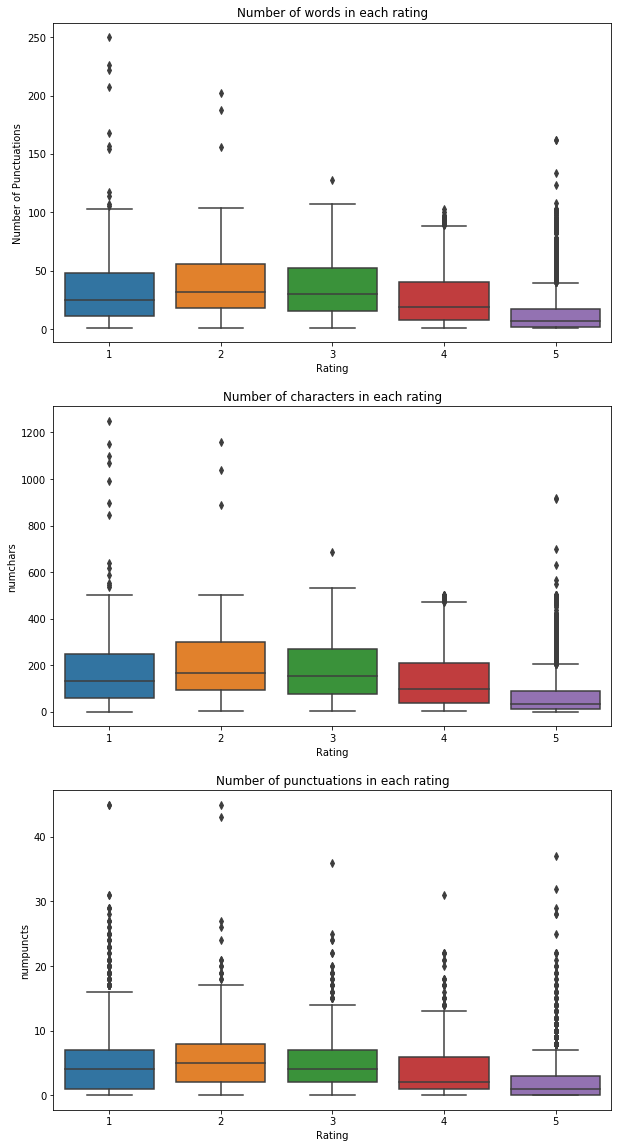

In [32]:
## Truncate some extreme values for better visuals ##
dfglobal['numwords'].loc[dfglobal['numwords']>250] = 250 
dfglobal['numchars'].loc[dfglobal['numchars']>1250] = 1250
dfglobal['numpuncts'].loc[dfglobal['numpuncts']>45] = 45

f, axes = plt.subplots(3, 1, figsize=(10,20))

sns.boxplot(x='score', y='numwords', data=dfglobal, ax=axes[0])
axes[0].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Words', fontsize=10)
axes[0].set_title("Number of words in each rating", fontsize=12)

sns.boxplot(x='score', y='numchars', data=dfglobal, ax=axes[1])
axes[1].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Characters', fontsize=10)
axes[1].set_title("Number of characters in each rating", fontsize=12)

sns.boxplot(x='score', y='numpuncts', data=dfglobal, ax=axes[2])
axes[2].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Punctuations', fontsize=10)
axes[2].set_title("Number of punctuations in each rating", fontsize=12)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


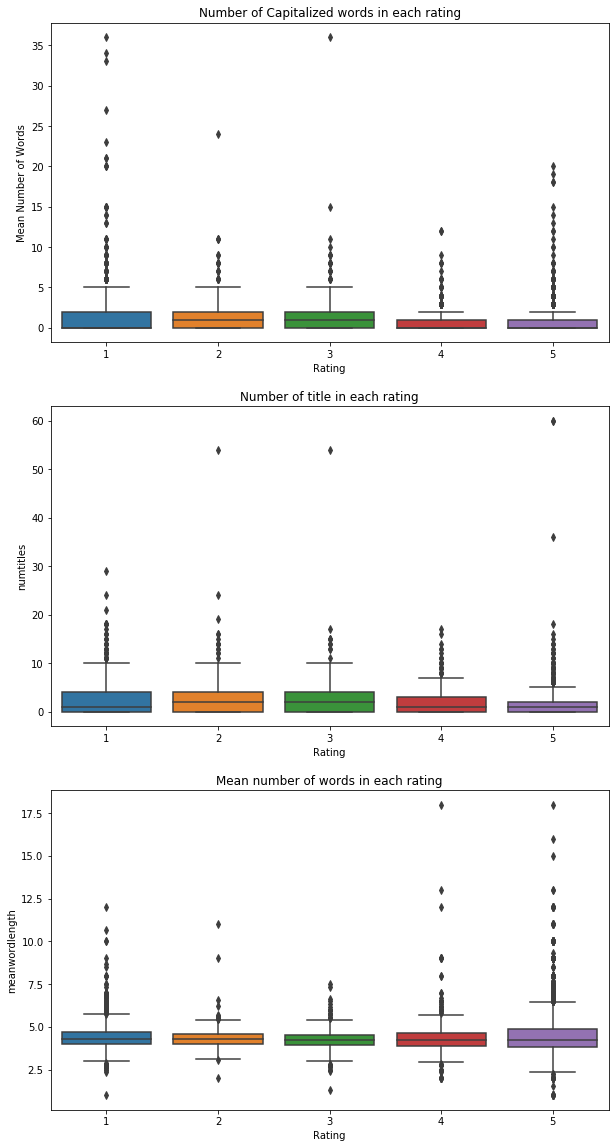

In [33]:
dfglobal['numcapts'].loc[dfglobal['numcapts']>36] = 36 
dfglobal['numtitles'].loc[dfglobal['numtitles']>60] = 60
dfglobal['meanwordlength'].loc[dfglobal['meanwordlength']>18] = 18

f, axes = plt.subplots(3, 1, figsize=(10,20))

sns.boxplot(x='score', y='numcapts', data=dfglobal, ax=axes[0])
axes[0].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Capitalized Words', fontsize=10)
axes[0].set_title("Number of Capitalized words in each rating", fontsize=12)

sns.boxplot(x='score', y='numtitles', data=dfglobal, ax=axes[1])
axes[1].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Title Characters', fontsize=10)
axes[1].set_title("Number of title in each rating", fontsize=12)

sns.boxplot(x='score', y='meanwordlength', data=dfglobal, ax=axes[2])
axes[2].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Mean Number of Words', fontsize=10)
axes[2].set_title("Mean number of words in each rating", fontsize=12)
plt.show()

## Meta Features for ROM Sea

In [34]:
dfsea["numwords"] = dfsea["content"].apply(lambda x: len(str(x).split()))

dfsea["numuniquewords"] = dfsea["content"].apply(lambda x: len(set(str(x).split())))

dfsea["numchars"] = dfsea["content"].apply(lambda x: len(str(x)))

dfsea["numpuncts"] = dfsea['content'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

dfsea["numcapts"] = dfsea["content"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

dfsea["numtitles"] = dfsea["content"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

dfsea["meanwordlength"] = dfsea["content"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


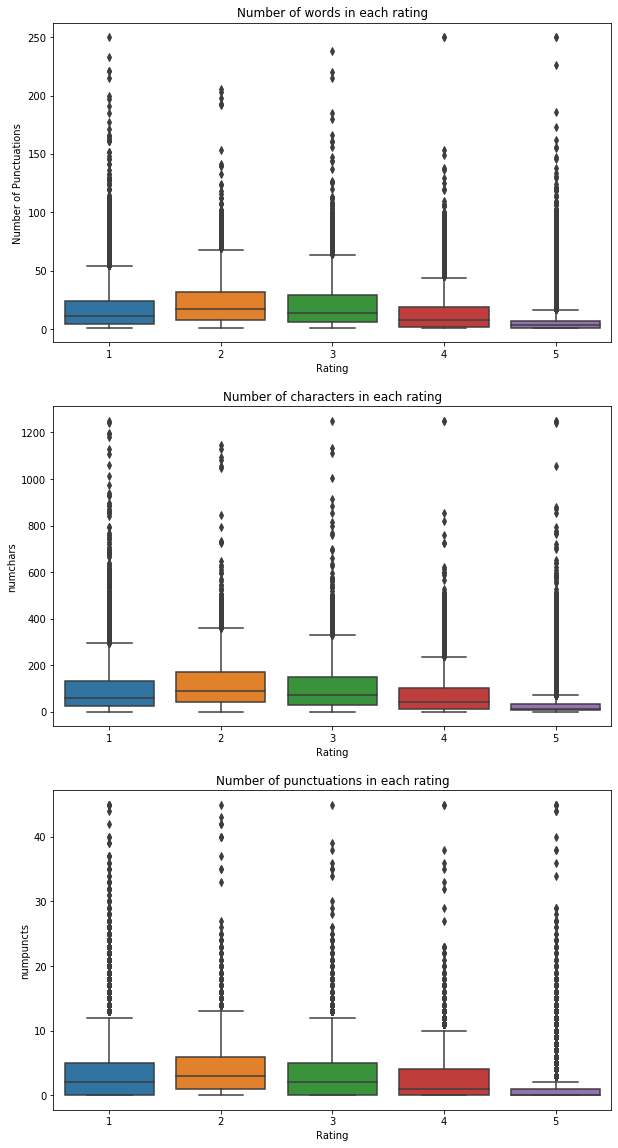

In [35]:
## Truncate some extreme values for better visuals ##
dfsea['numwords'].loc[dfsea['numwords']>250] = 250 
dfsea['numchars'].loc[dfsea['numchars']>1250] = 1250
dfsea['numpuncts'].loc[dfsea['numpuncts']>45] = 45

f, axes = plt.subplots(3, 1, figsize=(10,20))

sns.boxplot(x='score', y='numwords', data=dfsea, ax=axes[0])
axes[0].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Words', fontsize=10)
axes[0].set_title("Number of words in each rating", fontsize=12)

sns.boxplot(x='score', y='numchars', data=dfsea, ax=axes[1])
axes[1].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Characters', fontsize=10)
axes[1].set_title("Number of characters in each rating", fontsize=12)

sns.boxplot(x='score', y='numpuncts', data=dfsea, ax=axes[2])
axes[2].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Punctuations', fontsize=10)
axes[2].set_title("Number of punctuations in each rating", fontsize=12)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


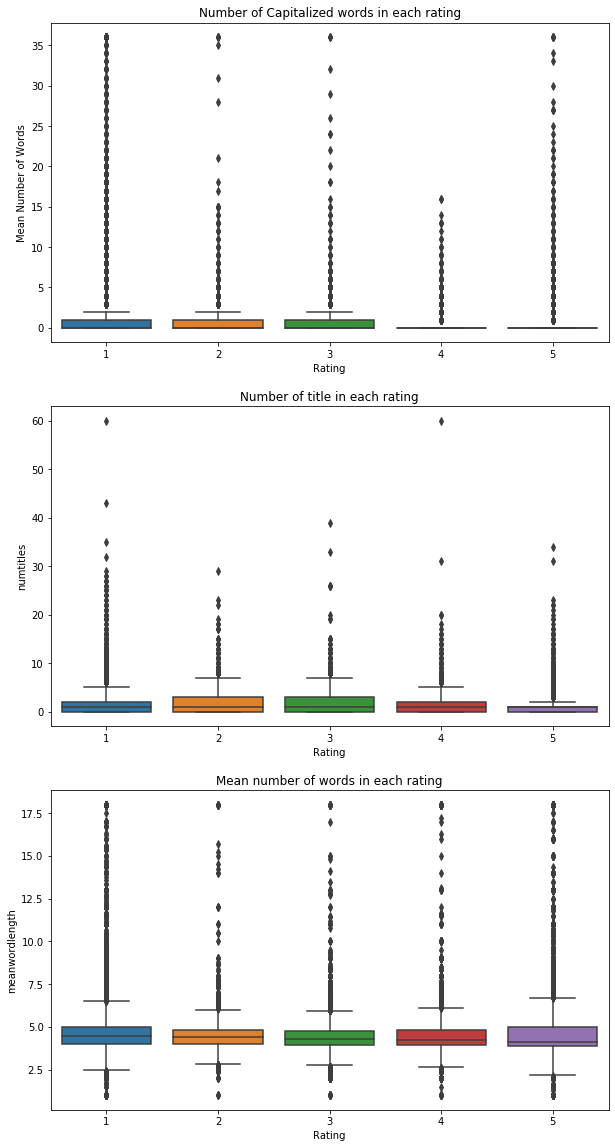

In [36]:
dfsea['numcapts'].loc[dfsea['numcapts']>36] = 36 
dfsea['numtitles'].loc[dfsea['numtitles']>60] = 60
dfsea['meanwordlength'].loc[dfsea['meanwordlength']>18] = 18

f, axes = plt.subplots(3, 1, figsize=(10,20))

sns.boxplot(x='score', y='numcapts', data=dfsea, ax=axes[0])
axes[0].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Capitalized Words', fontsize=10)
axes[0].set_title("Number of Capitalized words in each rating", fontsize=12)

sns.boxplot(x='score', y='numtitles', data=dfsea, ax=axes[1])
axes[1].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Title Characters', fontsize=10)
axes[1].set_title("Number of title in each rating", fontsize=12)

sns.boxplot(x='score', y='meanwordlength', data=dfsea, ax=axes[2])
axes[2].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Mean Number of Words', fontsize=10)
axes[2].set_title("Mean number of words in each rating", fontsize=12)
plt.show()

## Meta Features for Ragnarok Mobile Global on Apple Store

In [37]:
dfapple["numwords"] = dfapple["content"].apply(lambda x: len(str(x).split()))

dfapple["numuniquewords"] = dfapple["content"].apply(lambda x: len(set(str(x).split())))

dfapple["numchars"] = dfapple["content"].apply(lambda x: len(str(x)))

dfapple["numpuncts"] = dfapple['content'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

dfapple["numcapts"] = dfapple["content"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

dfapple["numtitles"] = dfapple["content"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

dfapple["meanwordlength"] = dfapple["content"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

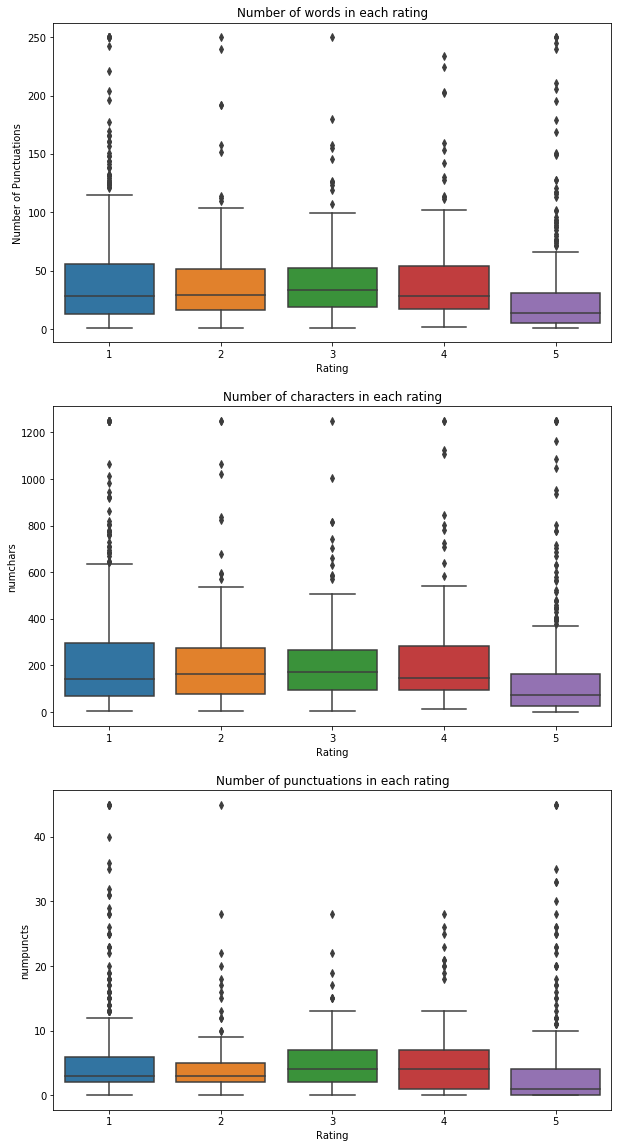

In [39]:
## Truncate some extreme values for better visuals ##
dfapple['numwords'].loc[dfapple['numwords']>250] = 250 
dfapple['numchars'].loc[dfapple['numchars']>1250] = 1250
dfapple['numpuncts'].loc[dfapple['numpuncts']>45] = 45

f, axes = plt.subplots(3, 1, figsize=(10,20))

sns.boxplot(x='score', y='numwords', data=dfapple, ax=axes[0])
axes[0].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Words', fontsize=10)
axes[0].set_title("Number of words in each rating", fontsize=12)

sns.boxplot(x='score', y='numchars', data=dfapple, ax=axes[1])
axes[1].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Characters', fontsize=10)
axes[1].set_title("Number of characters in each rating", fontsize=12)

sns.boxplot(x='score', y='numpuncts', data=dfapple, ax=axes[2])
axes[2].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Punctuations', fontsize=10)
axes[2].set_title("Number of punctuations in each rating", fontsize=12)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


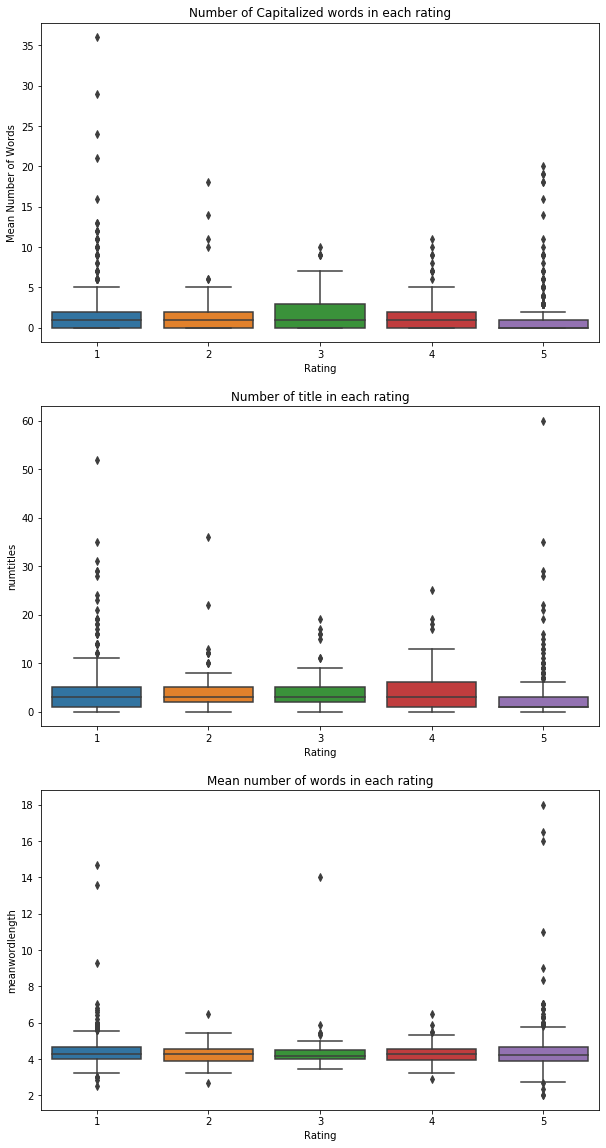

In [40]:
dfapple['numcapts'].loc[dfapple['numcapts']>36] = 36 
dfapple['numtitles'].loc[dfapple['numtitles']>60] = 60
dfapple['meanwordlength'].loc[dfapple['meanwordlength']>18] = 18

f, axes = plt.subplots(3, 1, figsize=(10,20))

sns.boxplot(x='score', y='numcapts', data=dfapple, ax=axes[0])
axes[0].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Capitalized Words', fontsize=10)
axes[0].set_title("Number of Capitalized words in each rating", fontsize=12)

sns.boxplot(x='score', y='numtitles', data=dfapple, ax=axes[1])
axes[1].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Title Characters', fontsize=10)
axes[1].set_title("Number of title in each rating", fontsize=12)

sns.boxplot(x='score', y='meanwordlength', data=dfapple, ax=axes[2])
axes[2].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Mean Number of Words', fontsize=10)
axes[2].set_title("Mean number of words in each rating", fontsize=12)
plt.show()

==================================================================================================================

# Tokenizing

In [41]:
# Remove common words
stopwords_list = stopwords.words('english') + list(string.punctuation)
# Remove more punctuation
stopwords_list += ["''", '""', '...', '``']
# Remove random numerals
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# Remove contractions
stopwords_list += ["'d", "'ve", "ca", "n't",  "'t", "'re", "'ll", "'s"]

In [42]:
def process_reviews(reviews):
    tokens = nltk.word_tokenize(reviews)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed   

In [43]:
# Separating reviews into their scores.

rating1global = dfglobal.loc[dfglobal['score'] == 1]
rating2global = dfglobal.loc[dfglobal['score'] == 2]
rating3global = dfglobal.loc[dfglobal['score'] == 3]
rating4global = dfglobal.loc[dfglobal['score'] == 4]
rating5global = dfglobal.loc[dfglobal['score'] == 5]

rating1sea = dfsea.loc[dfsea['score'] == 1]
rating2sea = dfsea.loc[dfsea['score'] == 2]
rating3sea = dfsea.loc[dfsea['score'] == 3]
rating4sea = dfsea.loc[dfsea['score'] == 4]
rating5sea = dfsea.loc[dfsea['score'] == 5]

rating1apple = dfapple.loc[dfapple['score'] == 1]
rating2apple = dfapple.loc[dfapple['score'] == 2]
rating3apple = dfapple.loc[dfapple['score'] == 3]
rating4apple = dfapple.loc[dfapple['score'] == 4]
rating5apple = dfapple.loc[dfapple['score'] == 5]

In [44]:
starttime = datetime.now()

rating1global['wordlist'] = rating1global['content'].apply(lambda x: process_reviews(x))
rating2global['wordlist'] = rating2global['content'].apply(lambda x: process_reviews(x))
rating3global['wordlist'] = rating3global['content'].apply(lambda x: process_reviews(x))
rating4global['wordlist'] = rating4global['content'].apply(lambda x: process_reviews(x))
rating5global['wordlist'] = rating5global['content'].apply(lambda x: process_reviews(x))

rating1sea['wordlist'] = rating1sea['content'].apply(lambda x: process_reviews(x))
rating2sea['wordlist'] = rating2sea['content'].apply(lambda x: process_reviews(x))
rating3sea['wordlist'] = rating3sea['content'].apply(lambda x: process_reviews(x))
rating4sea['wordlist'] = rating4sea['content'].apply(lambda x: process_reviews(x))
rating5sea['wordlist'] = rating5sea['content'].apply(lambda x: process_reviews(x))

rating1apple['wordlist'] = rating1apple['content'].apply(lambda x: process_reviews(x))
rating2apple['wordlist'] = rating2apple['content'].apply(lambda x: process_reviews(x))
rating3apple['wordlist'] = rating3apple['content'].apply(lambda x: process_reviews(x))
rating4apple['wordlist'] = rating4apple['content'].apply(lambda x: process_reviews(x))
rating5apple['wordlist'] = rating5apple['content'].apply(lambda x: process_reviews(x))

print(datetime.now() - starttime)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

0:00:15.523645


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [45]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

In [46]:
starttime = datetime.now()

rating1global['wordlistlem'] = rating1global['wordlist'].apply(lemmatize_text)
rating2global['wordlistlem'] = rating2global['wordlist'].apply(lemmatize_text)
rating3global['wordlistlem'] = rating3global['wordlist'].apply(lemmatize_text)
rating4global['wordlistlem'] = rating4global['wordlist'].apply(lemmatize_text)
rating5global['wordlistlem'] = rating5global['wordlist'].apply(lemmatize_text)

rating1sea['wordlistlem'] = rating1sea['wordlist'].apply(lemmatize_text)
rating2sea['wordlistlem'] = rating2sea['wordlist'].apply(lemmatize_text)
rating3sea['wordlistlem'] = rating3sea['wordlist'].apply(lemmatize_text)
rating4sea['wordlistlem'] = rating4sea['wordlist'].apply(lemmatize_text)
rating5sea['wordlistlem'] = rating5sea['wordlist'].apply(lemmatize_text)

rating1apple['wordlistlem'] = rating1apple['wordlist'].apply(lemmatize_text)
rating2apple['wordlistlem'] = rating2apple['wordlist'].apply(lemmatize_text)
rating3apple['wordlistlem'] = rating3apple['wordlist'].apply(lemmatize_text)
rating4apple['wordlistlem'] = rating4apple['wordlist'].apply(lemmatize_text)
rating5apple['wordlistlem'] = rating5apple['wordlist'].apply(lemmatize_text)

print(datetime.now() - starttime)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

0:00:04.359517


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

# Saving Dataframes

In [47]:
# Saving tokens into a sub-folder in for tidiness.

from pathlib import Path

root = Path('.')

#global
my_path1 = root / "tokens" / "processedreviewrating1.pbz2"
my_path2 = root / "tokens" / "processedreviewrating2.pbz2"
my_path3 = root / "tokens" / "processedreviewrating3.pbz2"
my_path4 = root / "tokens" / "processedreviewrating4.pbz2"
my_path5 = root / "tokens" / "processedreviewrating5.pbz2"

#sea
my_path6 = root / "tokens" / "processedreviewrating6.pbz2"
my_path7 = root / "tokens" / "processedreviewrating7.pbz2"
my_path8 = root / "tokens" / "processedreviewrating8.pbz2"
my_path9 = root / "tokens" / "processedreviewrating9.pbz2"
my_path10 = root / "tokens" / "processedreviewrating10.pbz2"

#globalapple
my_path11 = root / "tokens" / "processedreviewrating11.pbz2"
my_path12 = root / "tokens" / "processedreviewrating12.pbz2"
my_path13 = root / "tokens" / "processedreviewrating13.pbz2"
my_path14 = root / "tokens" / "processedreviewrating14.pbz2"
my_path15 = root / "tokens" / "processedreviewrating15.pbz2"


import bz2

def compressed_pickle(path, data):
    with bz2.BZ2File(path, 'w') as f:
        pickle.dump(data, f)

In [48]:
compressed_pickle(my_path1, rating1global)
compressed_pickle(my_path2, rating2global)
compressed_pickle(my_path3, rating3global)
compressed_pickle(my_path4, rating4global)
compressed_pickle(my_path5, rating5global)

compressed_pickle(my_path6, rating1sea)
compressed_pickle(my_path7, rating2sea)
compressed_pickle(my_path8, rating3sea)
compressed_pickle(my_path9, rating4sea)
compressed_pickle(my_path10, rating5sea)

compressed_pickle(my_path11, rating1apple)
compressed_pickle(my_path12, rating2apple)
compressed_pickle(my_path13, rating3apple)
compressed_pickle(my_path14, rating4apple)
compressed_pickle(my_path15, rating5apple)

In [49]:
# Retrieve our pickled dataframes

rating1global = decompress_pickle(my_path1)
rating2global = decompress_pickle(my_path2)
rating3global = decompress_pickle(my_path3)
rating4global = decompress_pickle(my_path4)
rating5global = decompress_pickle(my_path5)

rating1sea = decompress_pickle(my_path6)
rating2sea = decompress_pickle(my_path7)
rating3sea = decompress_pickle(my_path8)
rating4sea = decompress_pickle(my_path9)
rating5sea = decompress_pickle(my_path10)

rating1apple = decompress_pickle(my_path11)
rating2apple = decompress_pickle(my_path12)
rating3apple = decompress_pickle(my_path13)
rating4apple = decompress_pickle(my_path14)
rating5apple = decompress_pickle(my_path15)

==================================================================================================================

# Word Frequency in all reviews

In [50]:
starttime = datetime.now()

processedreviewrating1global = [item for elem in rating1global['wordlistlem'] for item in elem]
processedreviewrating2global = [item for elem in rating2global['wordlistlem'] for item in elem]
processedreviewrating3global = [item for elem in rating3global['wordlistlem'] for item in elem]
processedreviewrating4global = [item for elem in rating4global['wordlistlem'] for item in elem]
processedreviewrating5global = [item for elem in rating5global['wordlistlem'] for item in elem]

processedreviewrating1sea = [item for elem in rating1sea['wordlistlem'] for item in elem]
processedreviewrating2sea = [item for elem in rating2sea['wordlistlem'] for item in elem]
processedreviewrating3sea = [item for elem in rating3sea['wordlistlem'] for item in elem]
processedreviewrating4sea = [item for elem in rating4sea['wordlistlem'] for item in elem]
processedreviewrating5sea = [item for elem in rating5sea['wordlistlem'] for item in elem]

processedreviewrating1apple = [item for elem in rating1apple['wordlistlem'] for item in elem]
processedreviewrating2apple = [item for elem in rating2apple['wordlistlem'] for item in elem]
processedreviewrating3apple = [item for elem in rating3apple['wordlistlem'] for item in elem]
processedreviewrating4apple = [item for elem in rating4apple['wordlistlem'] for item in elem]
processedreviewrating5apple = [item for elem in rating5apple['wordlistlem'] for item in elem]

print(datetime.now() - starttime)
print('------------')
print(len(processedreviewrating1global))
print(len(processedreviewrating2global))
print(len(processedreviewrating3global))
print(len(processedreviewrating4global))
print(len(processedreviewrating5global))
print('------------')
print(len(processedreviewrating1sea))
print(len(processedreviewrating2sea))
print(len(processedreviewrating3sea))
print(len(processedreviewrating4sea))
print(len(processedreviewrating5sea))
print('------------')
print(len(processedreviewrating1apple))
print(len(processedreviewrating2apple))
print(len(processedreviewrating3apple))
print(len(processedreviewrating4apple))
print(len(processedreviewrating5apple))

0:00:00.052375
------------
31872
8389
10854
9501
25098
------------
300646
35913
45632
41607
141578
------------
13965
2200
2891
2917
6907


In [51]:
totalprocessedreviewsglobal = processedreviewrating1global + processedreviewrating2global + processedreviewrating3global + processedreviewrating4global + processedreviewrating5global

totalprocessedreviewssea = processedreviewrating1sea + processedreviewrating2sea + processedreviewrating3sea + processedreviewrating4sea + processedreviewrating5sea

totalprocessedreviewsapple = processedreviewrating1apple + processedreviewrating2apple + processedreviewrating3apple + processedreviewrating4apple + processedreviewrating5apple

totalprocessedreviewsallglobal = totalprocessedreviewsglobal + totalprocessedreviewsapple

print(len(totalprocessedreviewsglobal))
print(len(totalprocessedreviewssea))
print(len(totalprocessedreviewsapple))
print(len(totalprocessedreviewsallglobal))

85714
565376
28880
114594


In [52]:
review_freqdistglobal = FreqDist(totalprocessedreviewsglobal)
review_freqdistsea = FreqDist(totalprocessedreviewssea)
review_freqdistapple = FreqDist(totalprocessedreviewsapple)
review_freqdistallglobal = FreqDist(totalprocessedreviewsallglobal)

print(review_freqdistglobal.most_common(20))
print('--------------------------------------------------')
print(review_freqdistsea.most_common(20))
print('--------------------------------------------------')
print(review_freqdistapple.most_common(20))
print('--------------------------------------------------')
print(review_freqdistallglobal.most_common(20))

[('game', 4872), ('play', 1160), ('time', 837), ('good', 778), ('get', 769), ('love', 708), ('great', 702), ('like', 674), ('fun', 637), ('screen', 605), ('even', 514), ('issue', 437), ('would', 423), ('fix', 421), ('day', 416), ('ragnarok', 414), ('really', 413), ('playing', 412), ('mobile', 406), ('back', 391)]
--------------------------------------------------
[('game', 33868), ('bug', 9620), ('good', 7923), ('fix', 6190), ('play', 5370), ('nice', 4879), ('player', 4602), ('please', 4423), ('love', 4265), ('time', 3899), ('great', 3558), ('cheater', 3425), ('many', 3403), ('devs', 3352), ('money', 3328), ('cant', 3245), ('like', 3240), ('still', 3160), ('server', 3048), ('update', 3041)]
--------------------------------------------------
[('game', 1521), ('’', 1326), ('play', 336), ('get', 298), ('time', 263), ('like', 240), ('even', 194), ('crash', 183), ('player', 177), ('character', 165), ('fix', 164), ('people', 161), ('love', 152), ('good', 152), ('fun', 147), ('money', 145), (

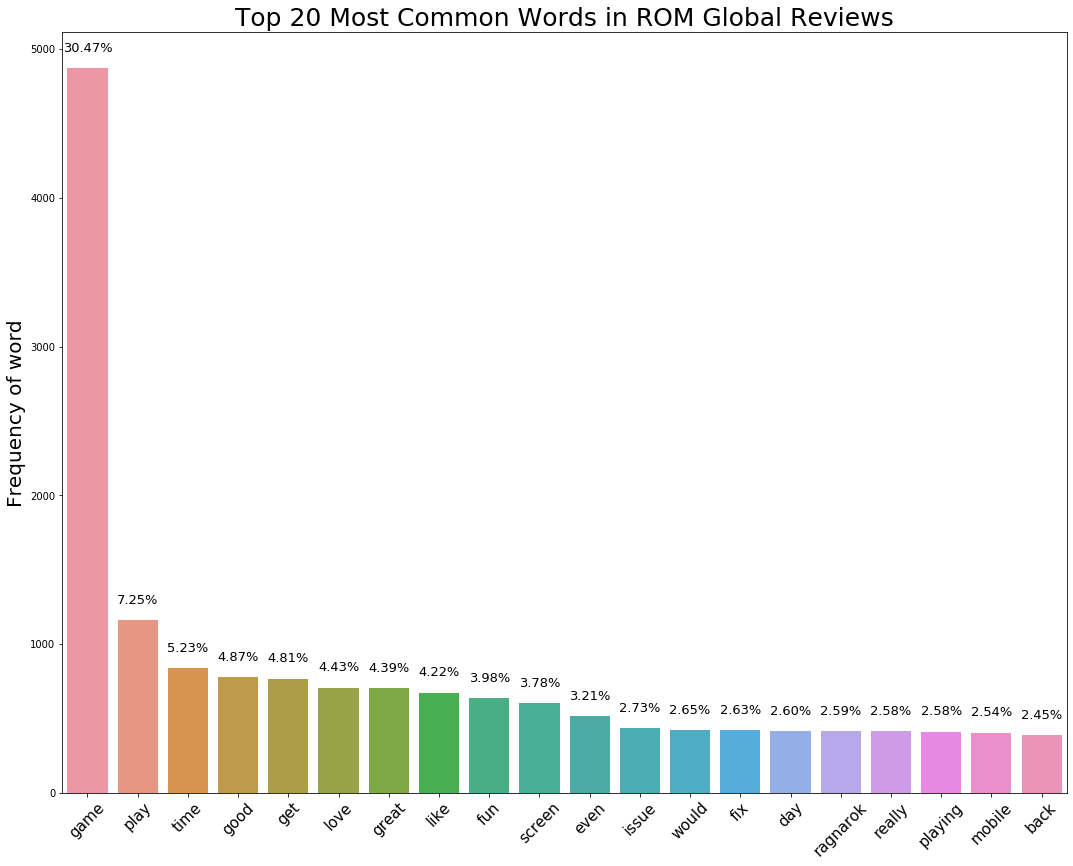

In [53]:
# Most common words in ROM Global

mostcommonwords20global = review_freqdistglobal.most_common(20)

yaxis20 = [val[1] for val in mostcommonwords20global]

xaxis20 = [val[0] for val in mostcommonwords20global]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis20, yaxis20)
plt.title('Top 20 Most Common Words in ROM Global Reviews', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis20))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

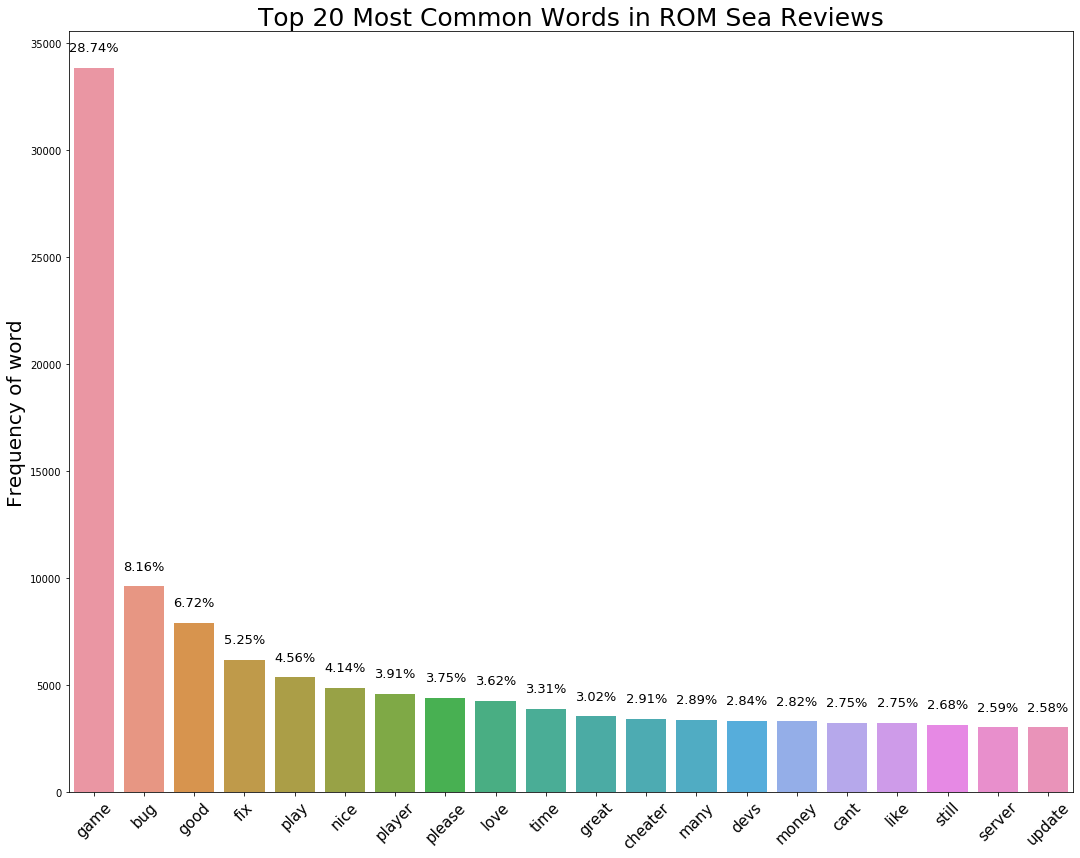

In [54]:
# Most common words in ROM Sea

mostcommonwords20sea = review_freqdistsea.most_common(20)

yaxis20 = [val[1] for val in mostcommonwords20sea]

xaxis20 = [val[0] for val in mostcommonwords20sea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis20, yaxis20)
plt.title('Top 20 Most Common Words in ROM Sea Reviews', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis20))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

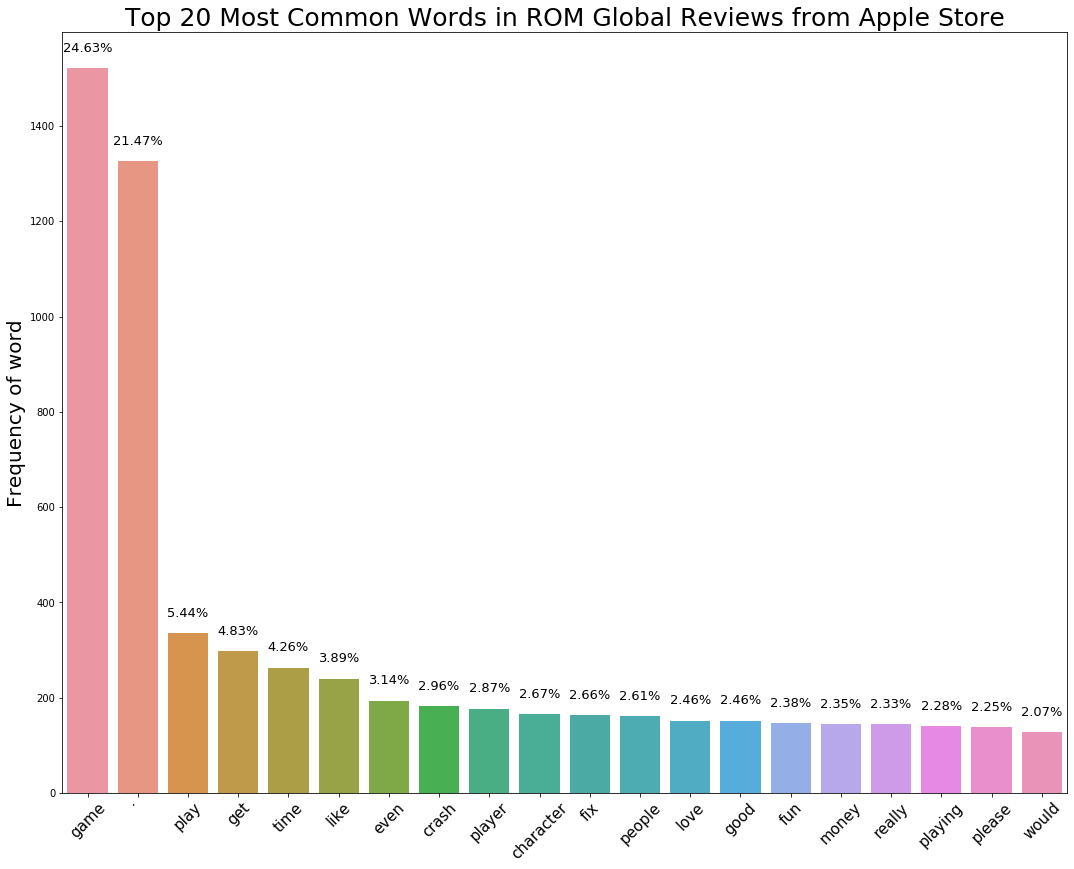

In [55]:
# Most common words in ROM Global from Apple Store

mostcommonwords20apple = review_freqdistapple.most_common(20)

yaxis20 = [val[1] for val in mostcommonwords20apple]

xaxis20 = [val[0] for val in mostcommonwords20apple]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis20, yaxis20)
plt.title('Top 20 Most Common Words in ROM Global Reviews from Apple Store', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis20))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

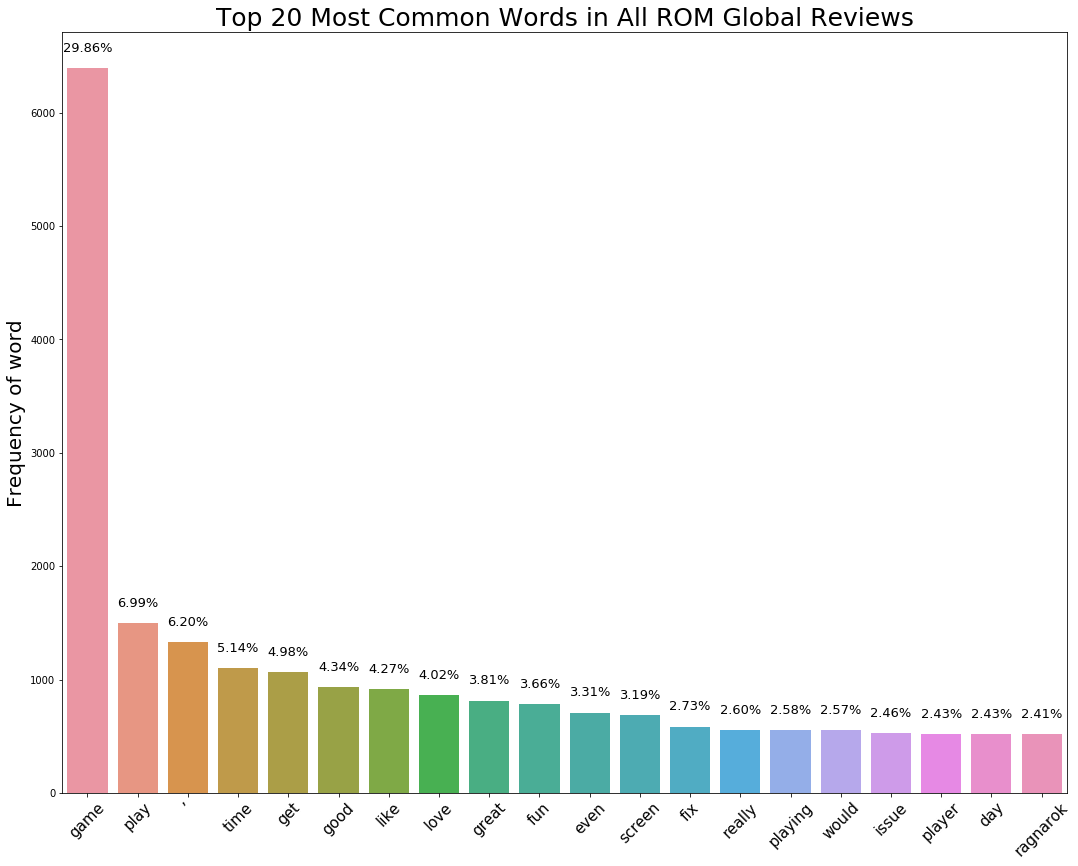

In [56]:
# Most common words in ROM all Global

mostcommonwords20allglobal = review_freqdistallglobal.most_common(20)

yaxis20 = [val[1] for val in mostcommonwords20allglobal]

xaxis20 = [val[0] for val in mostcommonwords20allglobal]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis20, yaxis20)
plt.title('Top 20 Most Common Words in All ROM Global Reviews', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis20))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

# Top 20 words per Rating [Lemmatized] for Global

In [65]:
uselesswords = ['game', 'play', 'get', 'still', 'would', "’"]

In [66]:
rating1lemglobal = processedreviewrating1global + processedreviewrating1apple

rating1lemglobal[:] = [x for x in rating1lemglobal if x not in uselesswords]

review1_freqdistglobal = FreqDist(rating1lemglobal)
review1_freqdistglobal.most_common(20)

[('even', 468),
 ('time', 467),
 ('screen', 323),
 ('player', 288),
 ('money', 287),
 ('fix', 284),
 ('like', 245),
 ('account', 218),
 ('day', 214),
 ('app', 208),
 ('start', 208),
 ('issue', 204),
 ('update', 196),
 ('keep', 196),
 ('download', 196),
 ('every', 187),
 ('phone', 186),
 ('crash', 186),
 ('support', 184),
 ('character', 183)]

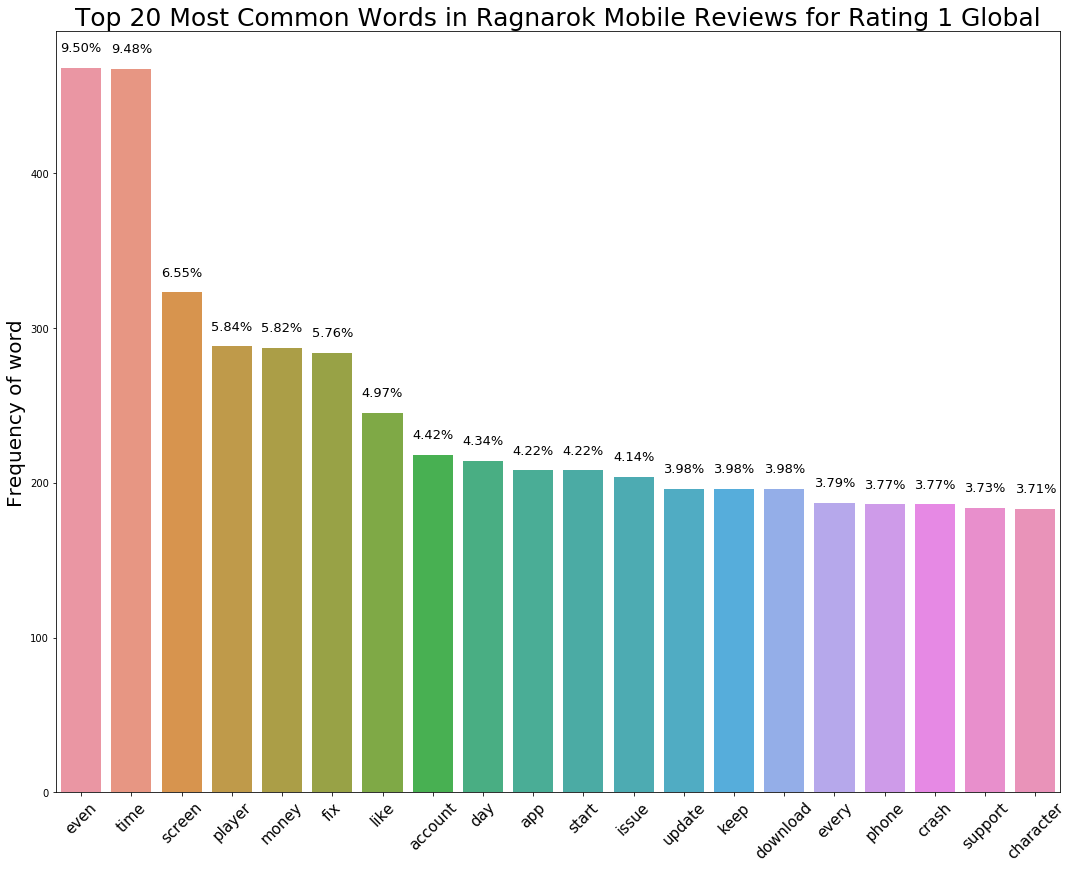

In [67]:
mostcommonwords201global = review1_freqdistglobal.most_common(20)

yaxis201global = [val[1] for val in mostcommonwords201global]

xaxis201global = [val[0] for val in mostcommonwords201global]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis201global, yaxis201global)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews for Rating 1 Global', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis201global))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [68]:
rating2lemglobal = processedreviewrating2global + processedreviewrating2apple

rating2lemglobal[:] = [x for x in rating2lemglobal if x not in uselesswords]

review2_freqdistglobal = FreqDist(rating2lemglobal)
review2_freqdistglobal.most_common(20)

[('time', 114),
 ('screen', 100),
 ('fix', 74),
 ('issue', 73),
 ('like', 68),
 ('even', 67),
 ('good', 61),
 ('every', 60),
 ('crash', 57),
 ('start', 57),
 ('day', 56),
 ('playing', 53),
 ('reinstall', 53),
 ('log', 51),
 ('fun', 50),
 ('keep', 50),
 ('really', 50),
 ('update', 49),
 ('star', 49),
 ('phone', 48)]

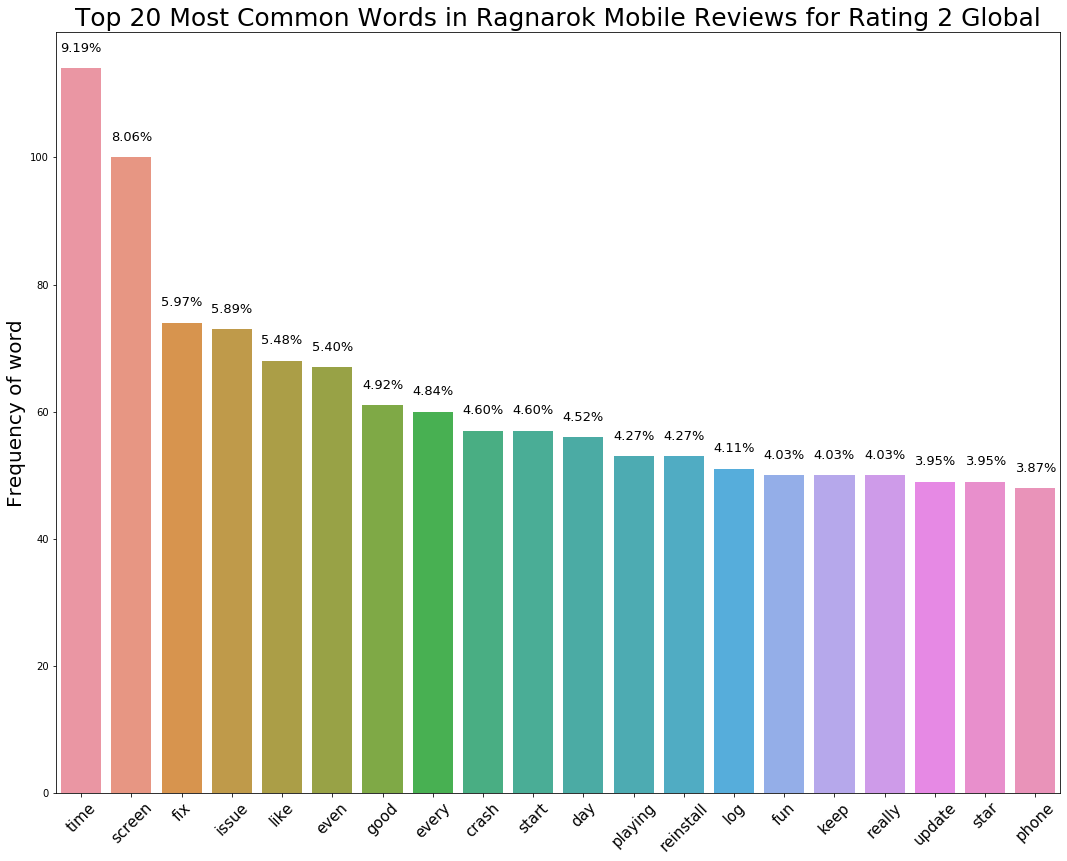

In [69]:
mostcommonwords202global = review2_freqdistglobal.most_common(20)

yaxis202global = [val[1] for val in mostcommonwords202global]

xaxis202global = [val[0] for val in mostcommonwords202global]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis202global, yaxis202global)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews for Rating 2 Global', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis202global))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [70]:
rating3lemglobal = processedreviewrating3global + processedreviewrating3apple

rating3lemglobal[:] = [x for x in rating3lemglobal if x not in uselesswords]

review3_freqdistglobal = FreqDist(rating3lemglobal)
review3_freqdistglobal.most_common(20)

[('time', 145),
 ('like', 120),
 ('screen', 116),
 ('fix', 104),
 ('good', 101),
 ('star', 90),
 ('every', 90),
 ('great', 83),
 ('playing', 82),
 ('issue', 79),
 ('really', 79),
 ('start', 77),
 ('fun', 76),
 ('need', 75),
 ('day', 71),
 ('please', 70),
 ('love', 70),
 ('character', 69),
 ('keep', 67),
 ('reinstall', 66)]

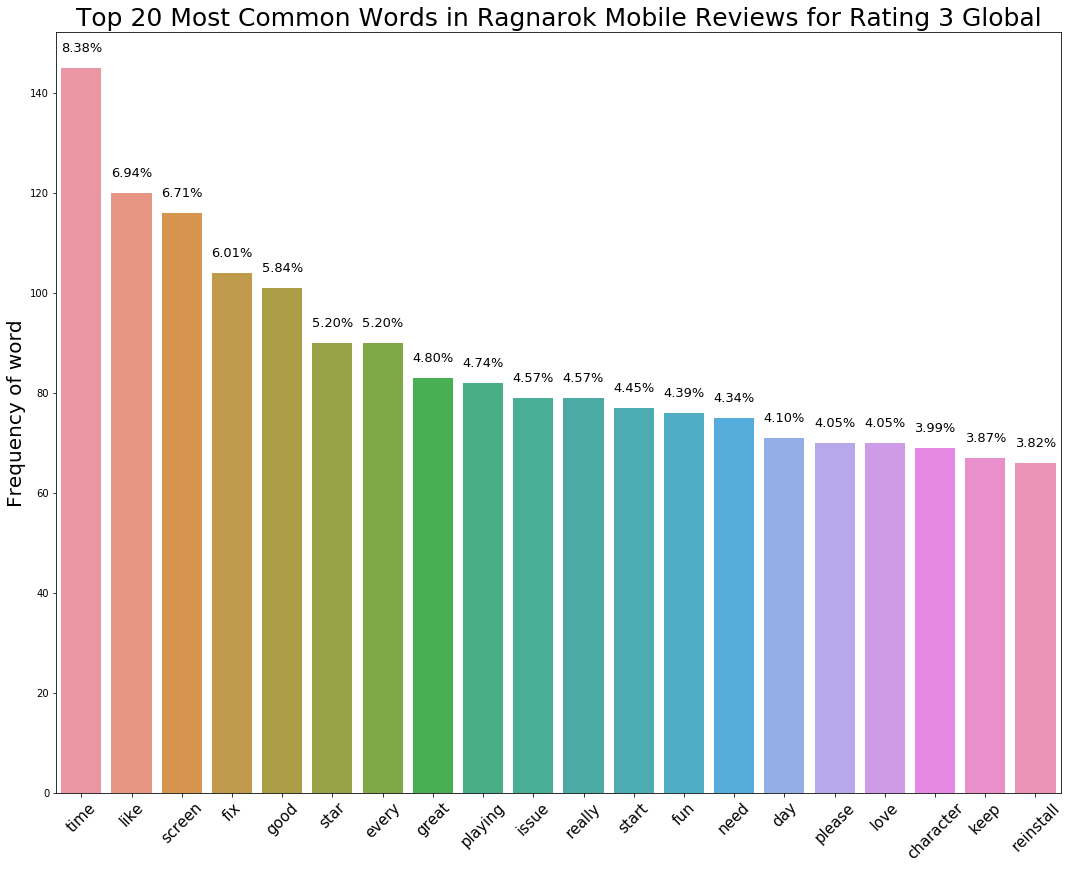

In [71]:
mostcommonwords203global = review3_freqdistglobal.most_common(20)

yaxis203global = [val[1] for val in mostcommonwords203global]

xaxis203global = [val[0] for val in mostcommonwords203global]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis203global, yaxis203global)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews for Rating 3 Global', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis203global))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [72]:
rating4lemglobal = processedreviewrating4global + processedreviewrating4apple

rating4lemglobal[:] = [x for x in rating4lemglobal if x not in uselesswords]

review4_freqdistglobal = FreqDist(rating4lemglobal)
review4_freqdistglobal.most_common(20)

[('good', 150),
 ('great', 132),
 ('like', 125),
 ('fun', 124),
 ('time', 114),
 ('love', 106),
 ('really', 80),
 ('issue', 74),
 ('screen', 74),
 ('playing', 69),
 ('star', 67),
 ('ragnarok', 65),
 ('fix', 64),
 ('lot', 62),
 ('far', 62),
 ('mobile', 60),
 ('ro', 59),
 ('quest', 58),
 ('one', 58),
 ('original', 53)]

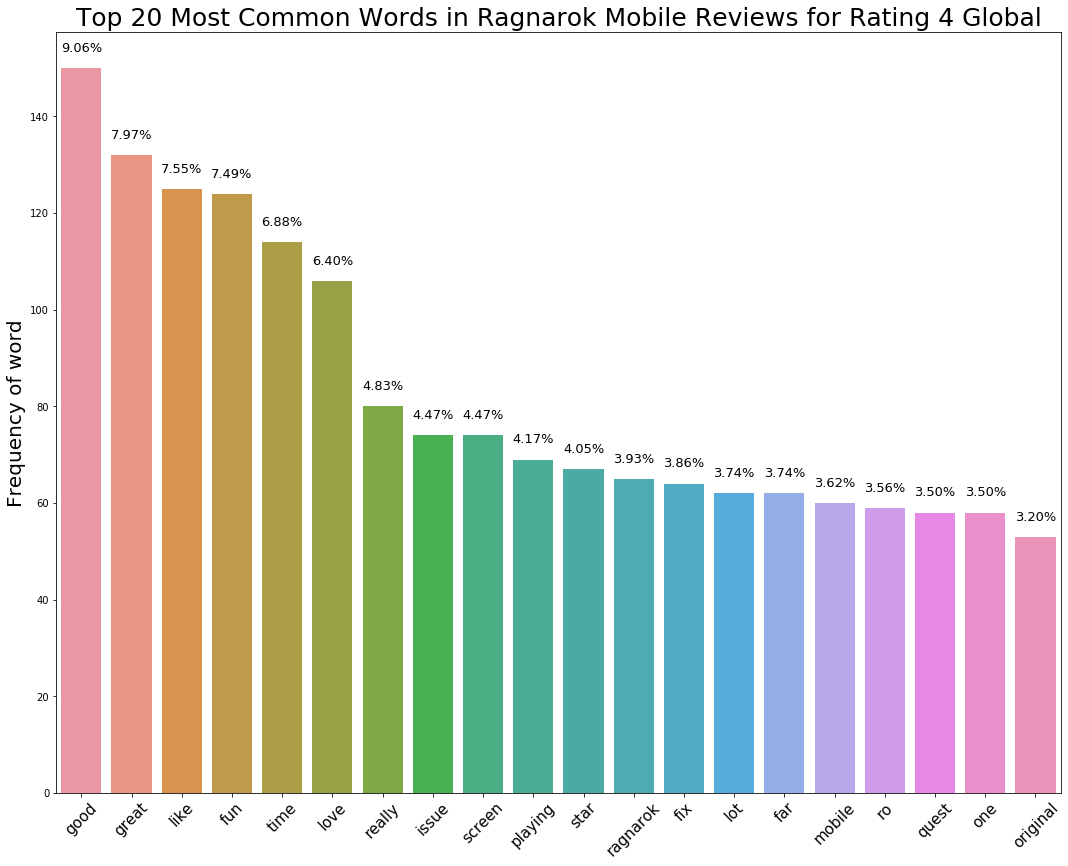

In [73]:
mostcommonwords204global = review4_freqdistglobal.most_common(20)

yaxis204global = [val[1] for val in mostcommonwords204global]

xaxis204global = [val[0] for val in mostcommonwords204global]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis204global, yaxis204global)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews for Rating 4 Global', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis204global))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [75]:
rating5lemglobal = processedreviewrating5global + processedreviewrating5apple

rating5lemglobal[:] = [x for x in rating5lemglobal if x not in uselesswords]

review5_freqdistglobal = FreqDist(rating5lemglobal)
review5_freqdistglobal.most_common(20)

[('love', 553),
 ('good', 490),
 ('great', 473),
 ('fun', 445),
 ('like', 356),
 ('mobile', 304),
 ('ragnarok', 291),
 ('ro', 261),
 ('time', 260),
 ('back', 253),
 ('best', 236),
 ('original', 219),
 ('really', 210),
 ('played', 197),
 ('old', 196),
 ('far', 194),
 ('playing', 189),
 ('amazing', 188),
 ('awesome', 174),
 ('nice', 170)]

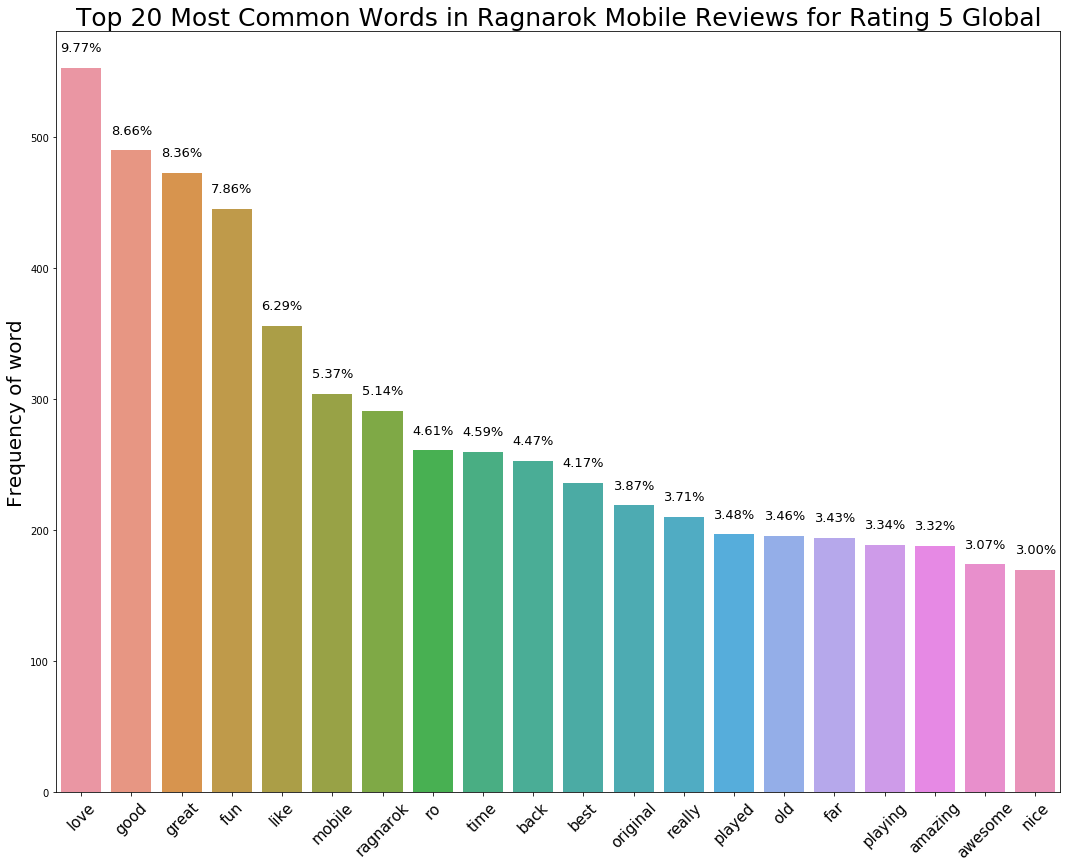

In [76]:
mostcommonwords205global = review5_freqdistglobal.most_common(20)

yaxis205global = [val[1] for val in mostcommonwords205global]

xaxis205global = [val[0] for val in mostcommonwords205global]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis205global, yaxis205global)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews for Rating 5 Global', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis205global))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

# Top 20 words per Rating [Lemmatized] for SEA

In [77]:
processedreviewrating1sea[:] = [x for x in processedreviewrating1sea if x not in uselesswords]

review1_freqdistsea = FreqDist(processedreviewrating1sea)
review1_freqdistsea.most_common(20)

[('bug', 7393),
 ('fix', 3655),
 ('cheater', 3233),
 ('player', 3167),
 ('money', 2944),
 ('devs', 2824),
 ('many', 2617),
 ('ban', 2316),
 ('lag', 2256),
 ('time', 2163),
 ('server', 2144),
 ('even', 1883),
 ('please', 1876),
 ('developer', 1861),
 ('update', 1790),
 ('cant', 1758),
 ('issue', 1589),
 ('day', 1450),
 ('lot', 1399),
 ('star', 1365)]

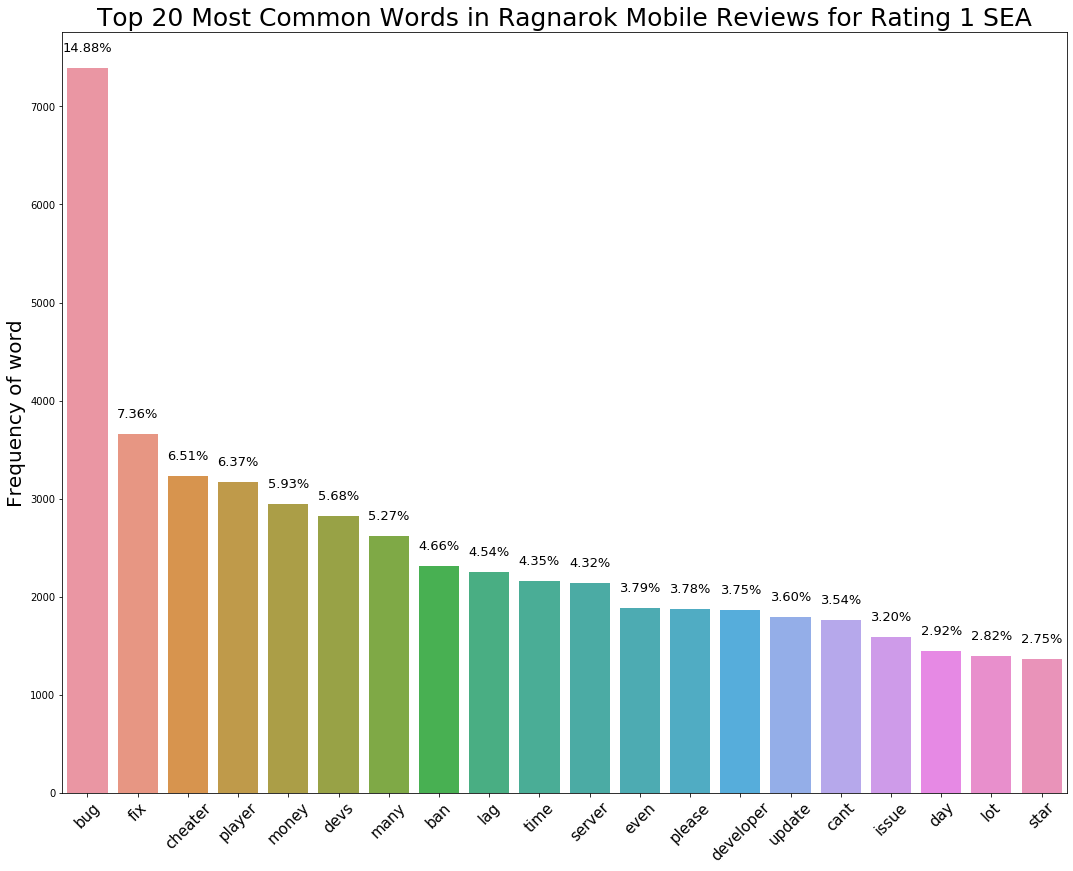

In [78]:
mostcommonwords201sea = review1_freqdistsea.most_common(20)

yaxis201sea = [val[1] for val in mostcommonwords201sea]

xaxis201sea = [val[0] for val in mostcommonwords201sea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis201sea, yaxis201sea)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews for Rating 1 SEA', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis201sea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [79]:
processedreviewrating2sea[:] = [x for x in processedreviewrating2sea if x not in uselesswords]

review2_freqdistsea = FreqDist(processedreviewrating2sea)
review2_freqdistsea.most_common(20)

[('fix', 506),
 ('please', 415),
 ('bug', 392),
 ('cant', 338),
 ('update', 328),
 ('time', 316),
 ('screen', 307),
 ('login', 288),
 ('player', 267),
 ('stuck', 257),
 ('even', 223),
 ('problem', 220),
 ('like', 216),
 ('good', 211),
 ('always', 202),
 ('log', 188),
 ('character', 187),
 ('phone', 176),
 ('server', 171),
 ('loading', 168)]

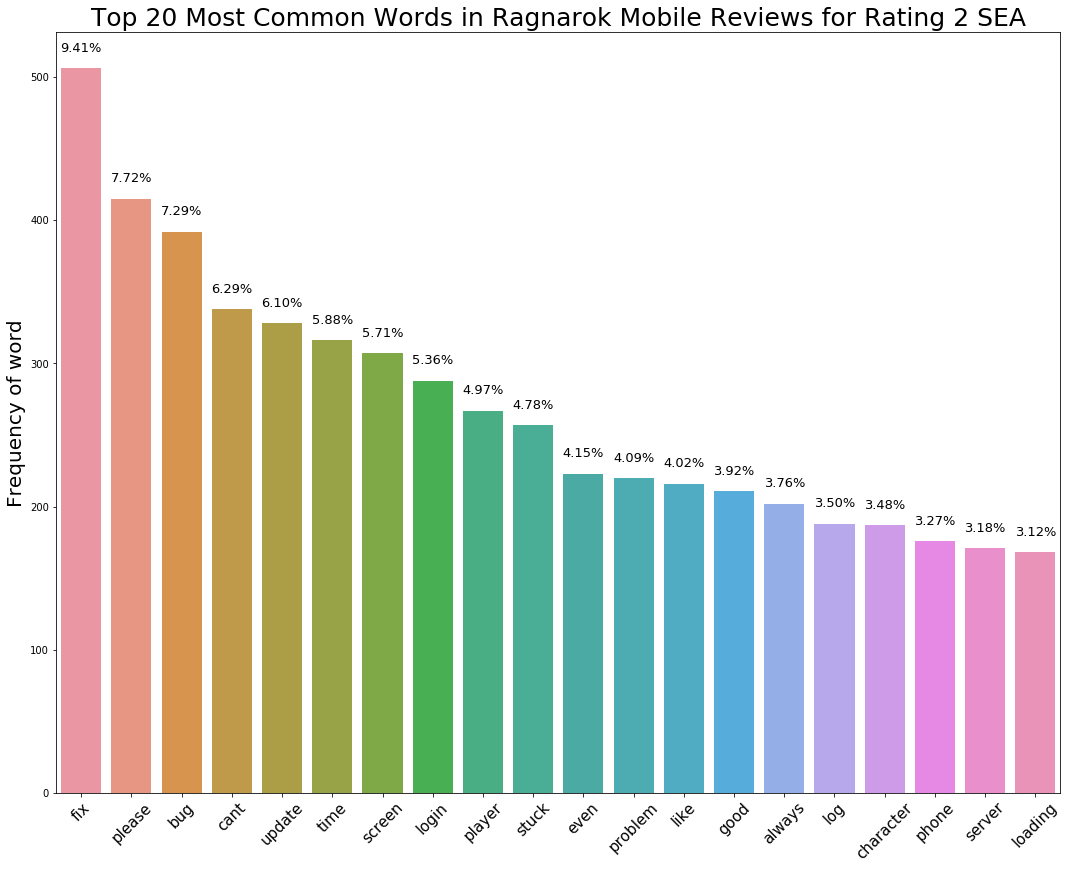

In [80]:
mostcommonwords202sea = review2_freqdistsea.most_common(20)

yaxis202sea = [val[1] for val in mostcommonwords202sea]

xaxis202sea = [val[0] for val in mostcommonwords202sea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis202sea, yaxis202sea)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews for Rating 2 SEA', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis202sea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [81]:
processedreviewrating3sea[:] = [x for x in processedreviewrating3sea if x not in uselesswords]

review3_freqdistsea = FreqDist(processedreviewrating3sea)
review3_freqdistsea.most_common(20)

[('fix', 676),
 ('please', 617),
 ('bug', 537),
 ('good', 458),
 ('cant', 435),
 ('screen', 379),
 ('time', 331),
 ('stuck', 326),
 ('update', 310),
 ('character', 302),
 ('player', 299),
 ('log', 298),
 ('login', 298),
 ('like', 291),
 ('loading', 271),
 ('problem', 255),
 ('help', 239),
 ('need', 228),
 ('many', 225),
 ('phone', 216)]

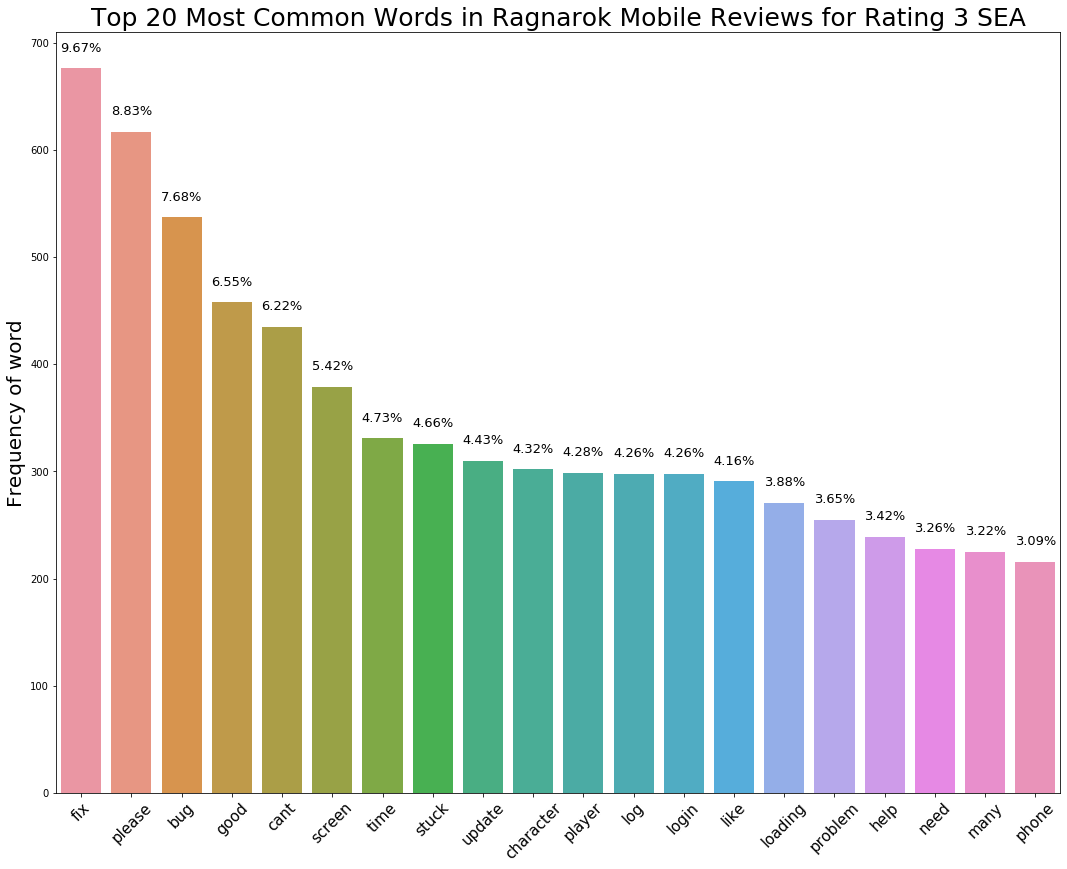

In [82]:
mostcommonwords203sea = review3_freqdistsea.most_common(20)

yaxis203sea = [val[1] for val in mostcommonwords203sea]

xaxis203sea = [val[0] for val in mostcommonwords203sea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis203sea, yaxis203sea)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews for Rating 3 SEA', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis203sea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [83]:
processedreviewrating4sea[:] = [x for x in processedreviewrating4sea if x not in uselesswords]

review4_freqdistsea = FreqDist(processedreviewrating4sea)
review4_freqdistsea.most_common(20)

[('good', 889),
 ('please', 518),
 ('fix', 503),
 ('bug', 502),
 ('nice', 451),
 ('great', 353),
 ('like', 325),
 ('player', 278),
 ('time', 272),
 ('cant', 262),
 ('love', 243),
 ('need', 236),
 ('star', 230),
 ('update', 222),
 ('screen', 213),
 ('hope', 204),
 ('make', 196),
 ('login', 192),
 ('back', 183),
 ('stuck', 180)]

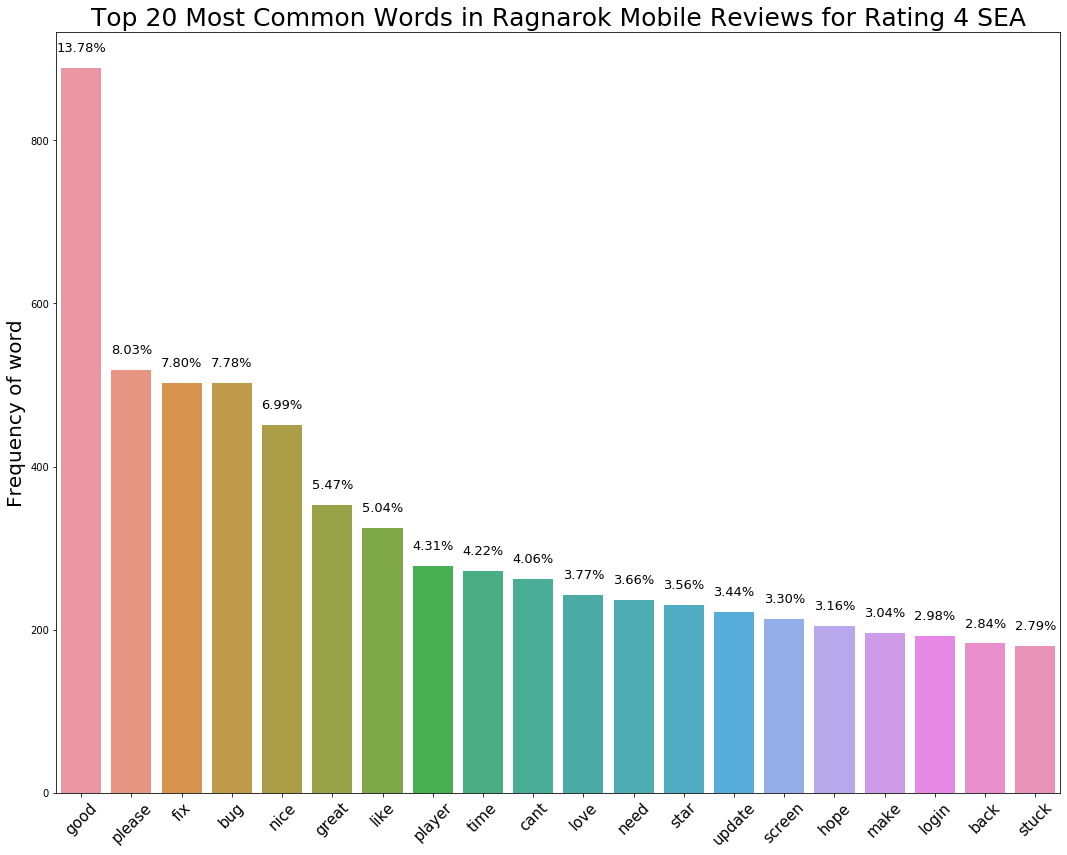

In [84]:
mostcommonwords204sea = review4_freqdistsea.most_common(20)

yaxis204sea = [val[1] for val in mostcommonwords204sea]

xaxis204sea = [val[0] for val in mostcommonwords204sea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis204sea, yaxis204sea)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews for Rating 4 SEA', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis204sea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [85]:
processedreviewrating5sea[:] = [x for x in processedreviewrating5sea if x not in uselesswords]

review5_freqdistsea = FreqDist(processedreviewrating5sea)
review5_freqdistsea.most_common(20)

[('good', 5046),
 ('nice', 4076),
 ('love', 2997),
 ('great', 2534),
 ('best', 2182),
 ('back', 1413),
 ('awesome', 1356),
 ('like', 1228),
 ('ragnarok', 1105),
 ('please', 997),
 ('nostalgic', 939),
 ('ever', 867),
 ('old', 862),
 ('fix', 850),
 ('time', 817),
 ('memory', 809),
 ('bug', 796),
 ('mobile', 710),
 ('fun', 678),
 ('really', 663)]

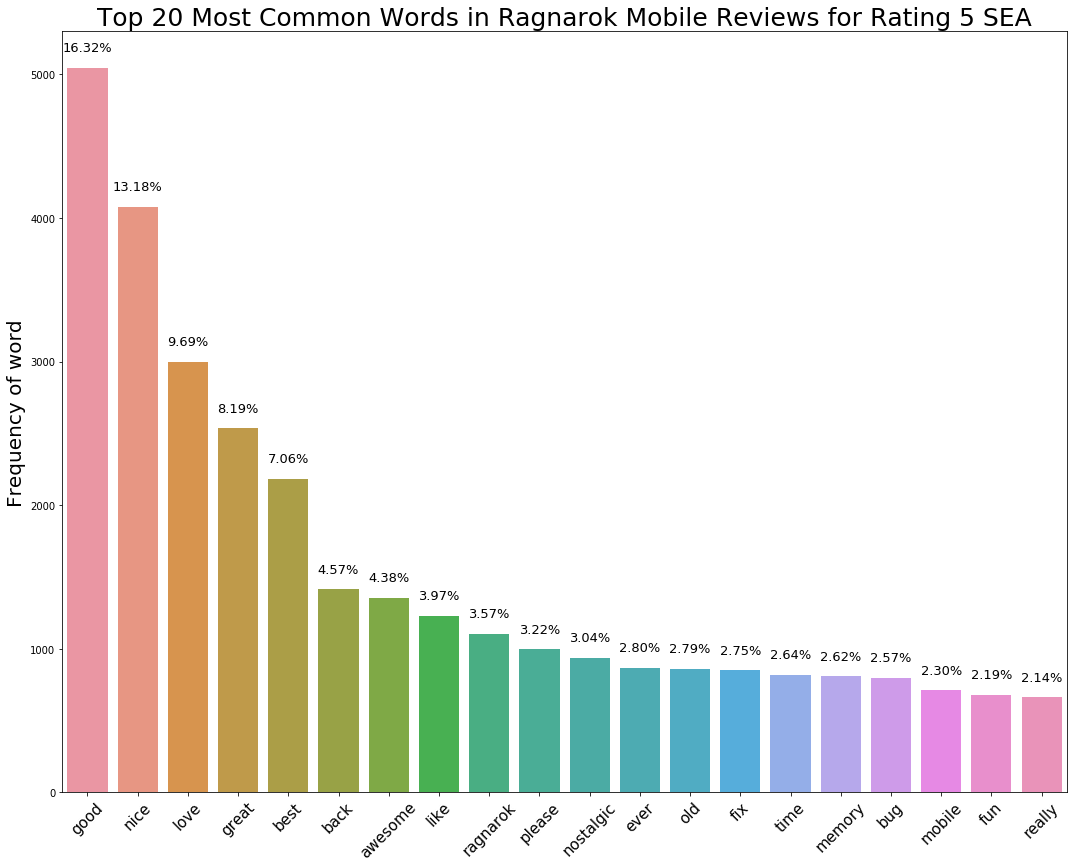

In [86]:
mostcommonwords205sea = review5_freqdistsea.most_common(20)

yaxis205sea = [val[1] for val in mostcommonwords205sea]

xaxis205sea = [val[0] for val in mostcommonwords205sea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis205sea, yaxis205sea)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews for Rating 5 SEA', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis205sea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

# Bigrams/Trigrams overall for Global

In [87]:
def n_gramall(df_col, n=None):
    # Build the vectorizer, specify inputted n-gram, remove stop words
    vect = CountVectorizer(ngram_range = (n,n), stop_words = gramstopwords_list, min_df = 10)
    # fit/transform vectorizer on specified column
    vect_fit = vect.fit_transform(df_col.values.astype('U'))
    # get all words and store in a list
    word_list = vect.get_feature_names()
    # get a count of all the words
    count_list = vect_fit.toarray().sum(axis=0)
    #create a dictionary of word to count pairings
    count_dict = dict(zip(word_list, count_list))
    # sort the dictionary to show highest counted words on top
    sort_vocab = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)
    return sort_vocab

In [88]:
gramstopwords_list = stopwords.words('english') + list(string.punctuation)
gramstopwords_list += ["''", '""', '...', '``']

In [97]:
globalcontent = dfglobal['content'].append(dfapple['content'], ignore_index=True)
globalcontent

0       Game full of bots on auto-attack who kill all ...
1                                               fun gamee
2       Very nostalgic. They did an excellent job with...
3       Good graphics cute characters, fun to find and...
4                                   im new very nice game
                              ...                        
7846    The combat time doesn’t reset properly and inc...
7847                                            I love it
7848                                     It’s just... bad
7849    Brings back some childhood memories!
But bette...
7850                                       Enjoy the game
Name: content, Length: 7851, dtype: string

In [98]:
bigramallglobal = n_gramall(globalcontent, n=2)
bigramallglobal[:20]

[('great game', 325),
 ('love game', 273),
 ('play game', 250),
 ('good game', 219),
 ('please fix', 193),
 ('pay win', 144),
 ('fun game', 134),
 ('brings back', 124),
 ('ragnarok online', 121),
 ('every time', 104),
 ('playing game', 101),
 ('game play', 92),
 ('mobile game', 90),
 ('uninstall reinstall', 87),
 ('game crashes', 86),
 ('reinstall game', 86),
 ('start game', 86),
 ('game great', 84),
 ('loading screen', 81),
 ('like game', 79)]

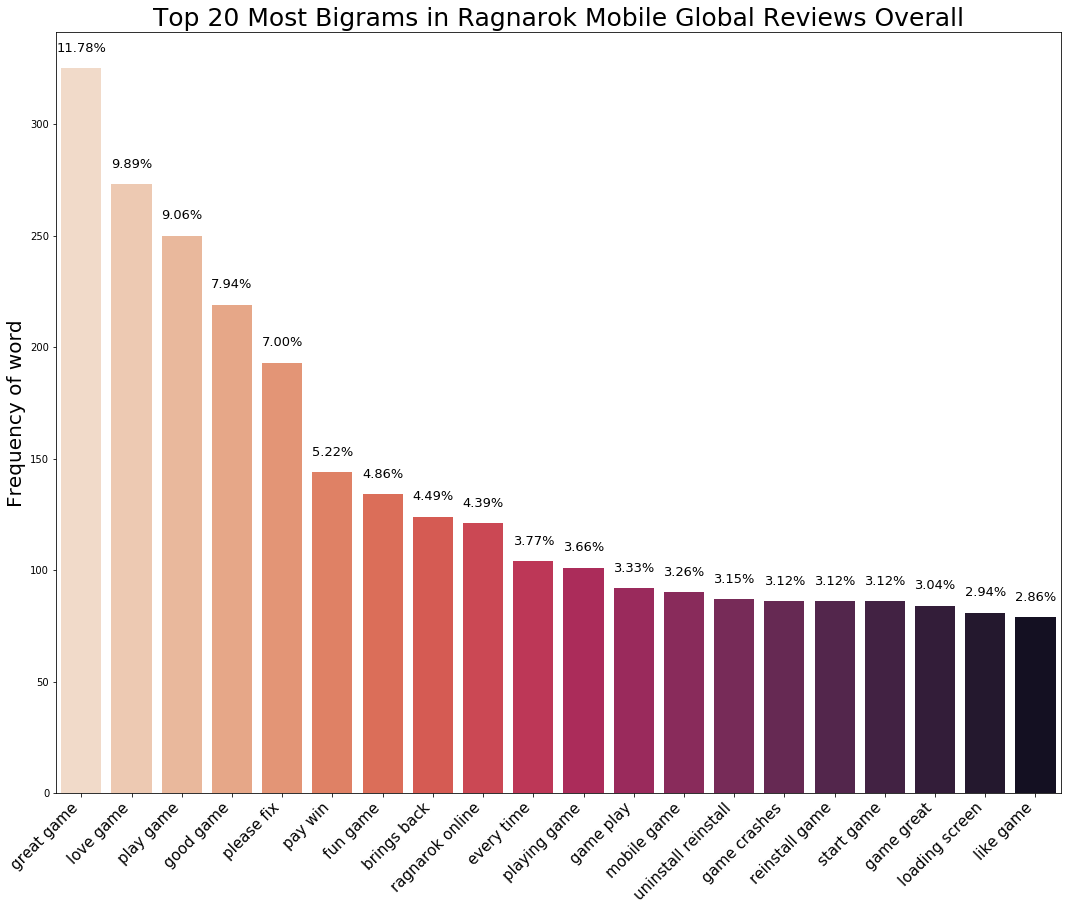

In [99]:
mostcommonwords20bigramglobal = bigramallglobal[:20]

yaxis20bigramglobal = [val[1] for val in mostcommonwords20bigramglobal]

xaxis20biramglobal = [val[0] for val in mostcommonwords20bigramglobal]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis20biramglobal, yaxis20bigramglobal, palette ="rocket_r")
plt.title('Top 20 Most Bigrams in Ragnarok Mobile Global Reviews Overall', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis20bigramglobal))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [100]:
trigramallglobal = n_gramall(globalcontent, n=3)
trigramallglobal[:20]

[('best game ever', 43),
 ('brings back memories', 35),
 ('uninstall reinstall game', 30),
 ('game keeps crashing', 29),
 ('game brings back', 28),
 ('touch start game', 28),
 ('stuck loading screen', 26),
 ('original ragnarok online', 23),
 ('using google account', 23),
 ('stuck login screen', 21),
 ('touch start screen', 20),
 ('want play game', 18),
 ('pay win game', 17),
 ('brings back many', 16),
 ('brings back old', 16),
 ('cant even play', 16),
 ('cant get past', 16),
 ('screen please fix', 16),
 ('even play game', 15),
 ('every time try', 15)]

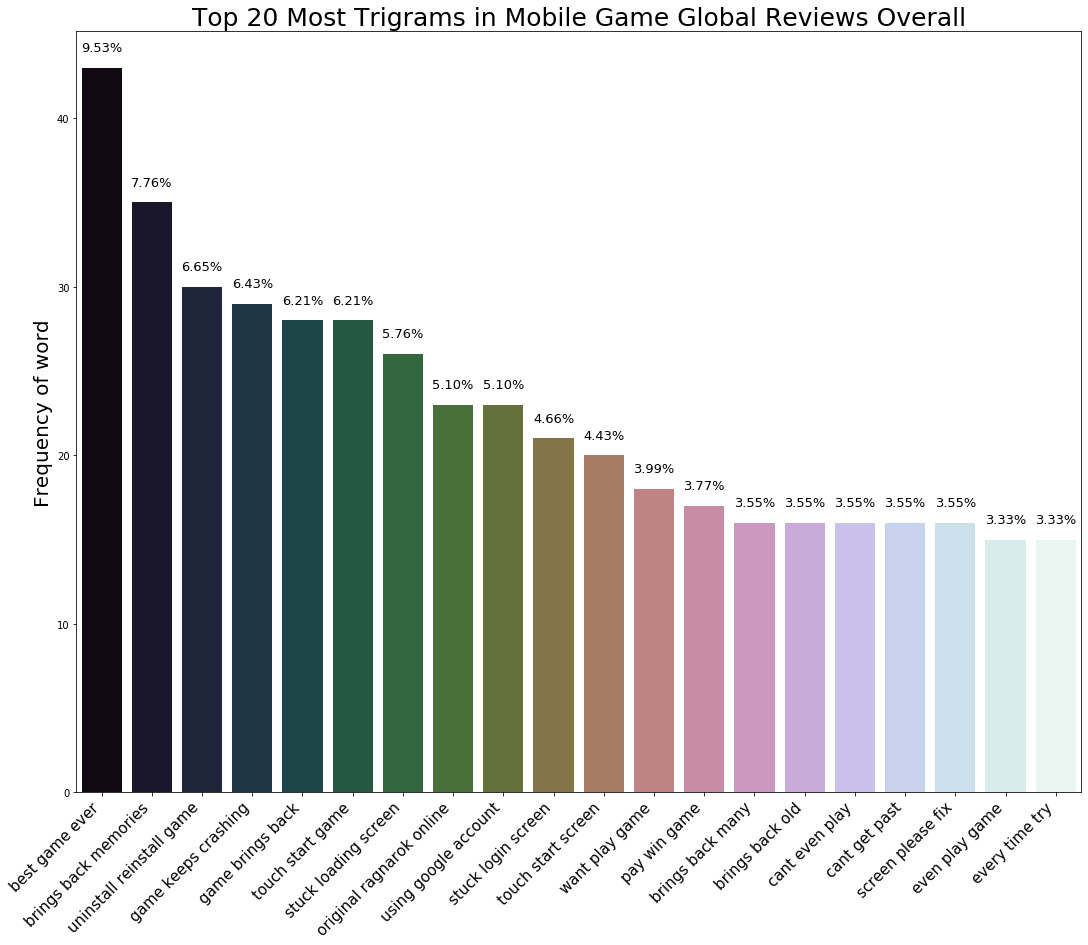

In [101]:
mostcommonwords20trigramglobal = trigramallglobal[:20]

yaxis20trigramglobal = [val[1] for val in mostcommonwords20trigramglobal]

xaxis20triramglobal = [val[0] for val in mostcommonwords20trigramglobal]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis20triramglobal, yaxis20trigramglobal, palette ="cubehelix")
plt.title('Top 20 Most Trigrams in Mobile Game Global Reviews Overall', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis20trigramglobal))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

# Bigrams/Trigrams overall for SEA

In [102]:
bigramallsea = n_gramall(dfsea['content'], n=2)
bigramallsea[:20]

[('good game', 2399),
 ('nice game', 2154),
 ('please fix', 1792),
 ('great game', 1689),
 ('love game', 1663),
 ('play game', 1313),
 ('pay win', 1121),
 ('many bugs', 962),
 ('3rd party', 906),
 ('best game', 885),
 ('game ever', 836),
 ('black screen', 766),
 ('add ons', 728),
 ('loading screen', 667),
 ('woe woc', 618),
 ('stuck loading', 604),
 ('game good', 585),
 ('playing game', 571),
 ('fix bugs', 533),
 ('15 days', 488)]

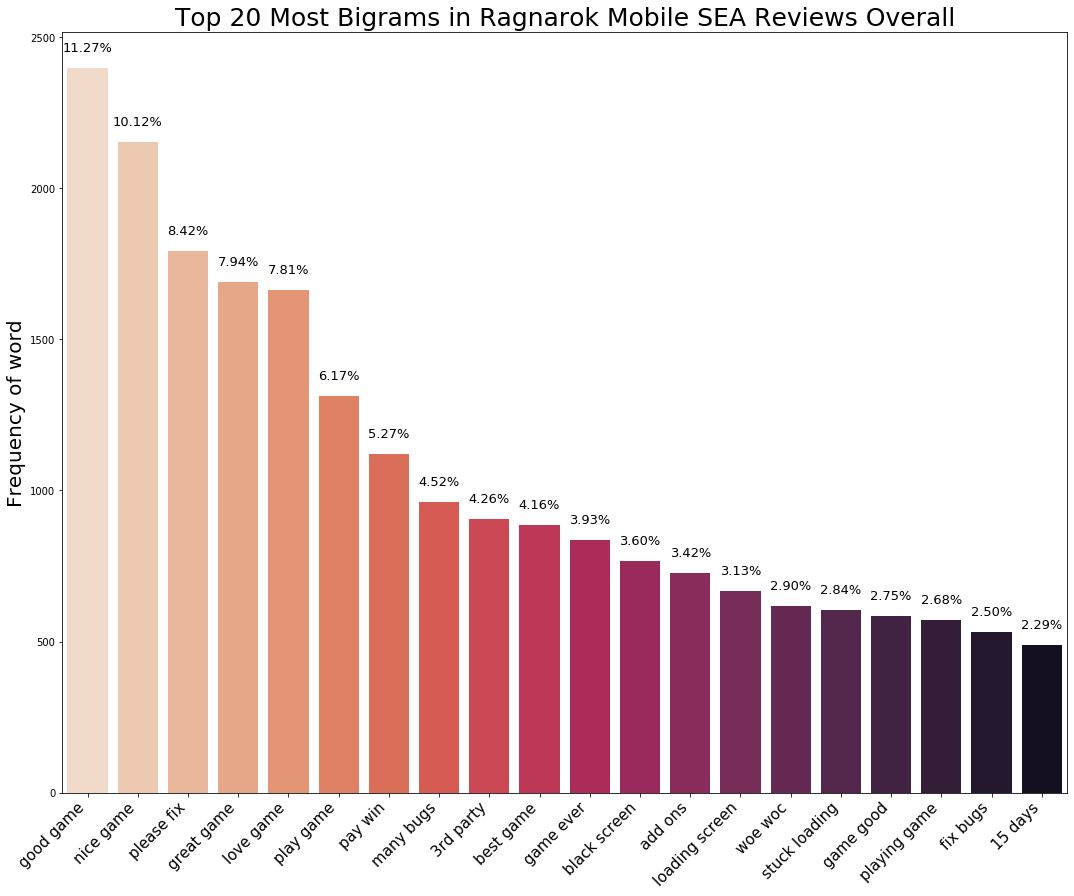

In [103]:
mostcommonwords20bigramsea = bigramallsea[:20]

yaxis20bigramsea = [val[1] for val in mostcommonwords20bigramsea]

xaxis20biramsea = [val[0] for val in mostcommonwords20bigramsea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis20biramsea, yaxis20bigramsea, palette ="rocket_r")
plt.title('Top 20 Most Bigrams in Ragnarok Mobile SEA Reviews Overall', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis20bigramsea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

# Bigrams/Trigrams for specific ratings for ROM Global

In [106]:
# Rating 1

globalcontent1 = rating1global['content'].append(rating1apple['content'], ignore_index=True)

bigram1global = n_gramall(globalcontent1, n=2)
bigram1global[:20]

[('play game', 139),
 ('please fix', 90),
 ('pay win', 73),
 ('every time', 54),
 ('cant even', 48),
 ('game crashes', 46),
 ('start game', 46),
 ('loading screen', 45),
 ('even play', 44),
 ('download game', 42),
 ('keeps crashing', 42),
 ('black screen', 40),
 ('get game', 40),
 ('playing game', 39),
 ('get past', 38),
 ('money game', 37),
 ('even get', 36),
 ('game even', 36),
 ('waste time', 36),
 ('3rd party', 35)]

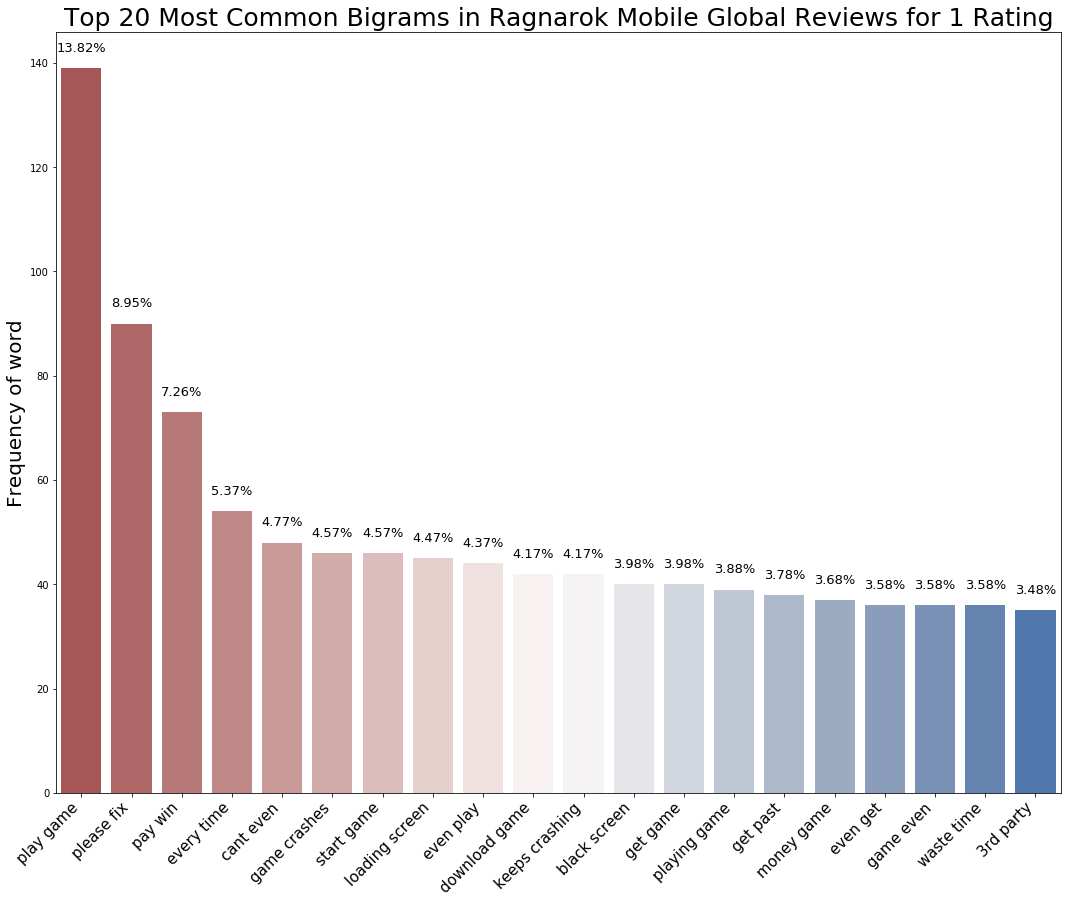

In [107]:
mostcommonwords201biglobal = bigram1global[:20]

yaxis201biglobal = [val[1] for val in mostcommonwords201biglobal]

xaxis201biglobal = [val[0] for val in mostcommonwords201biglobal]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis201biglobal, yaxis201biglobal, palette ="vlag_r")
plt.title('Top 20 Most Common Bigrams in Ragnarok Mobile Global Reviews for 1 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis201biglobal))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [108]:
trigram1global = n_gramall(globalcontent1, n=3)
trigram1global[:20]

[('game keeps crashing', 17),
 ('using google account', 14),
 ('cant even play', 13),
 ('stuck loading screen', 12),
 ('even play game', 11),
 ('uninstall reinstall game', 11),
 ('pay win game', 10),
 ('screen please fix', 10),
 ('touch start game', 10)]

-------

In [109]:
# Rating 2
globalcontent2 = rating2global['content'].append(rating2apple['content'], ignore_index=True)

bigram2global = n_gramall(globalcontent2, n=2)
bigram2global[:20]

[('play game', 30),
 ('please fix', 27),
 ('reinstall game', 19),
 ('love game', 18),
 ('every time', 17),
 ('good game', 17),
 ('great game', 17),
 ('pay win', 16),
 ('like game', 15),
 ('uninstall reinstall', 15),
 ('login screen', 13),
 ('playing game', 12),
 ('able play', 11),
 ('enjoy game', 11),
 ('even play', 11),
 ('fun game', 11),
 ('game crashes', 11),
 ('loading screen', 11),
 ('start game', 11),
 ('touch start', 11)]

In [111]:
# Returns Nothing.

#trigram2 = n_gramall(globalcontent2, n=3)
#trigram2[:20]

--------

In [112]:
# Rating 3
globalcontent3 = rating3global['content'].append(rating3apple['content'], ignore_index=True)

bigram3global = n_gramall(globalcontent3, n=2)
bigram3global[:20]

[('love game', 41),
 ('please fix', 39),
 ('good game', 31),
 ('great game', 28),
 ('play game', 21),
 ('uninstall reinstall', 21),
 ('reinstall game', 20),
 ('touch start', 20),
 ('game great', 19),
 ('like game', 19),
 ('start game', 19),
 ('every time', 18),
 ('fun game', 17),
 ('every days', 16),
 ('login screen', 16),
 ('pay win', 16),
 ('game good', 14),
 ('start screen', 14),
 ('enjoy game', 13),
 ('give stars', 13)]

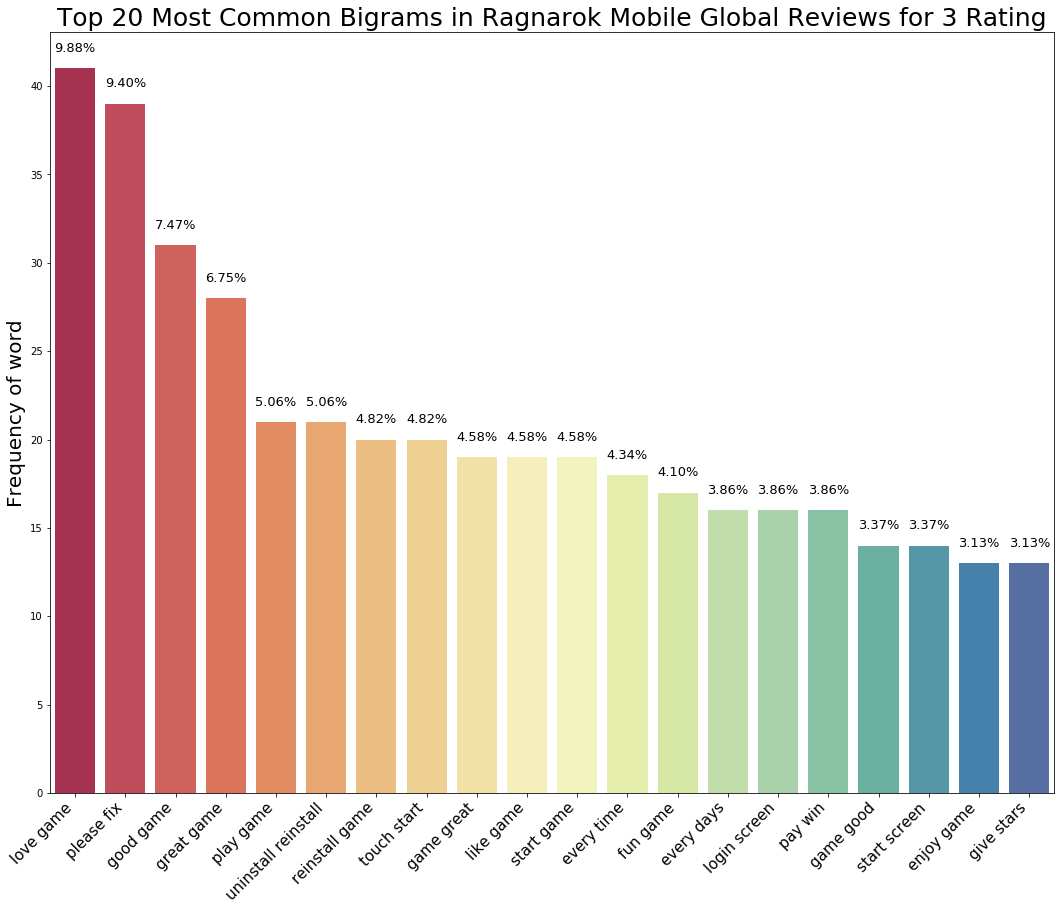

In [113]:
mostcommonwords203biglobal = bigram3global[:20]

yaxis203biglobal = [val[1] for val in mostcommonwords203biglobal]

xaxis203biglobal = [val[0] for val in mostcommonwords203biglobal]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis203biglobal, yaxis203biglobal, palette ="Spectral")
plt.title('Top 20 Most Common Bigrams in Ragnarok Mobile Global Reviews for 3 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis203biglobal))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [ ]:
# Returns nothing.

#trigram3global = n_gramall(globalcontent3, n=3)
#trigram3global[:20]

---------

In [114]:
# Rating 4

globalcontent4 = rating4global['content'].append(rating4apple['content'], ignore_index=True)

bigram4global = n_gramall(globalcontent4, n=2)
bigram4global[:20]

[('great game', 61),
 ('good game', 45),
 ('love game', 39),
 ('fun game', 28),
 ('ragnarok online', 25),
 ('please fix', 24),
 ('play game', 21),
 ('pretty good', 17),
 ('like game', 14),
 ('game play', 13),
 ('pay win', 13),
 ('pc version', 13),
 ('start screen', 13),
 ('brings back', 12),
 ('game fun', 12),
 ('game great', 12),
 ('game really', 12),
 ('get past', 12),
 ('pretty fun', 12),
 ('enjoy game', 11)]

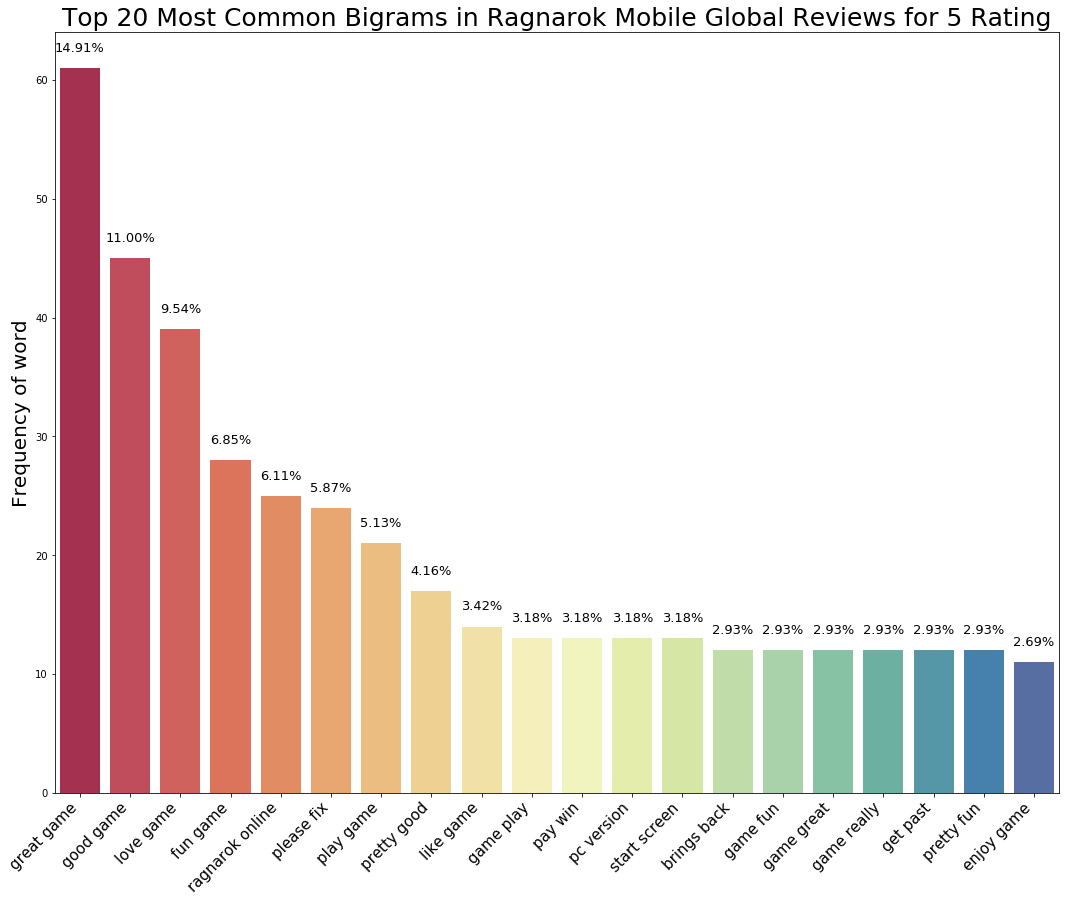

In [115]:
mostcommonwords204biglobal = bigram4global[:20]

yaxis204biglobal = [val[1] for val in mostcommonwords204biglobal]

xaxis204biglobal = [val[0] for val in mostcommonwords204biglobal]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis204biglobal, yaxis204biglobal, palette ="Spectral")
plt.title('Top 20 Most Common Bigrams in Ragnarok Mobile Global Reviews for 5 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis204biglobal))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [ ]:
# Returns nothing.

#trigram4global = n_gramall(globalcontent4, n=3)
#trigram4global[:20]

------

In [117]:
# Rating 5

globalcontent5 = rating5global['content'].append(rating5apple['content'], ignore_index=True)

bigram5global = n_gramall(globalcontent5, n=2)
bigram5global[:20]

[('great game', 184),
 ('love game', 142),
 ('good game', 102),
 ('brings back', 98),
 ('ragnarok online', 75),
 ('best game', 69),
 ('fun game', 67),
 ('awesome game', 56),
 ('mobile game', 53),
 ('amazing game', 52),
 ('game ever', 52),
 ('nice game', 49),
 ('pc version', 39),
 ('play game', 39),
 ('really fun', 38),
 ('game play', 37),
 ('original ragnarok', 36),
 ('original ro', 35),
 ('years ago', 35),
 ('back memories', 34)]

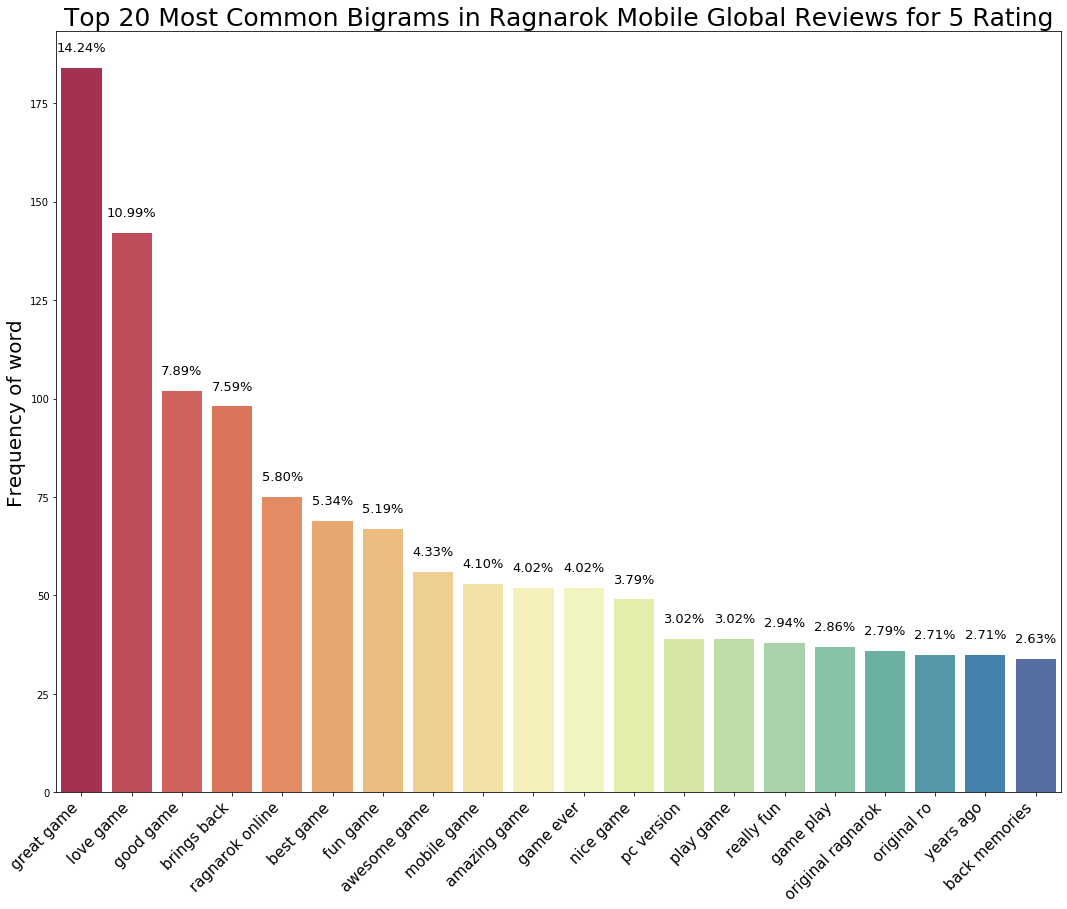

In [118]:
mostcommonwords205biglobal = bigram5global[:20]

yaxis205biglobal = [val[1] for val in mostcommonwords205biglobal]

xaxis205biglobal = [val[0] for val in mostcommonwords205biglobal]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis205biglobal, yaxis205biglobal, palette ="Spectral")
plt.title('Top 20 Most Common Bigrams in Ragnarok Mobile Global Reviews for 5 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis205biglobal))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [119]:
trigram5global = n_gramall(globalcontent5, n=3)
trigram5global[:20]

[('best game ever', 40),
 ('brings back memories', 29),
 ('game brings back', 22),
 ('original ragnarok online', 13),
 ('brings back many', 12),
 ('brings back old', 12),
 ('great game far', 10),
 ('love game much', 10)]

# Bigrams/Trigrams for specific ratings for ROM SEA

In [120]:
# Rating 1

bigram1sea = n_gramall(rating1sea['content'], n=2)
bigram1sea[:20]

[('pay win', 909),
 ('3rd party', 850),
 ('many bugs', 818),
 ('please fix', 782),
 ('play game', 742),
 ('add ons', 669),
 ('woe woc', 480),
 ('black screen', 475),
 ('15 days', 460),
 ('ban cheaters', 436),
 ('full bugs', 409),
 ('permanent ban', 405),
 ('love game', 396),
 ('perma ban', 391),
 ('fix bugs', 366),
 ('waste time', 351),
 ('good game', 338),
 ('money game', 328),
 ('many bug', 317),
 ('playing game', 310)]

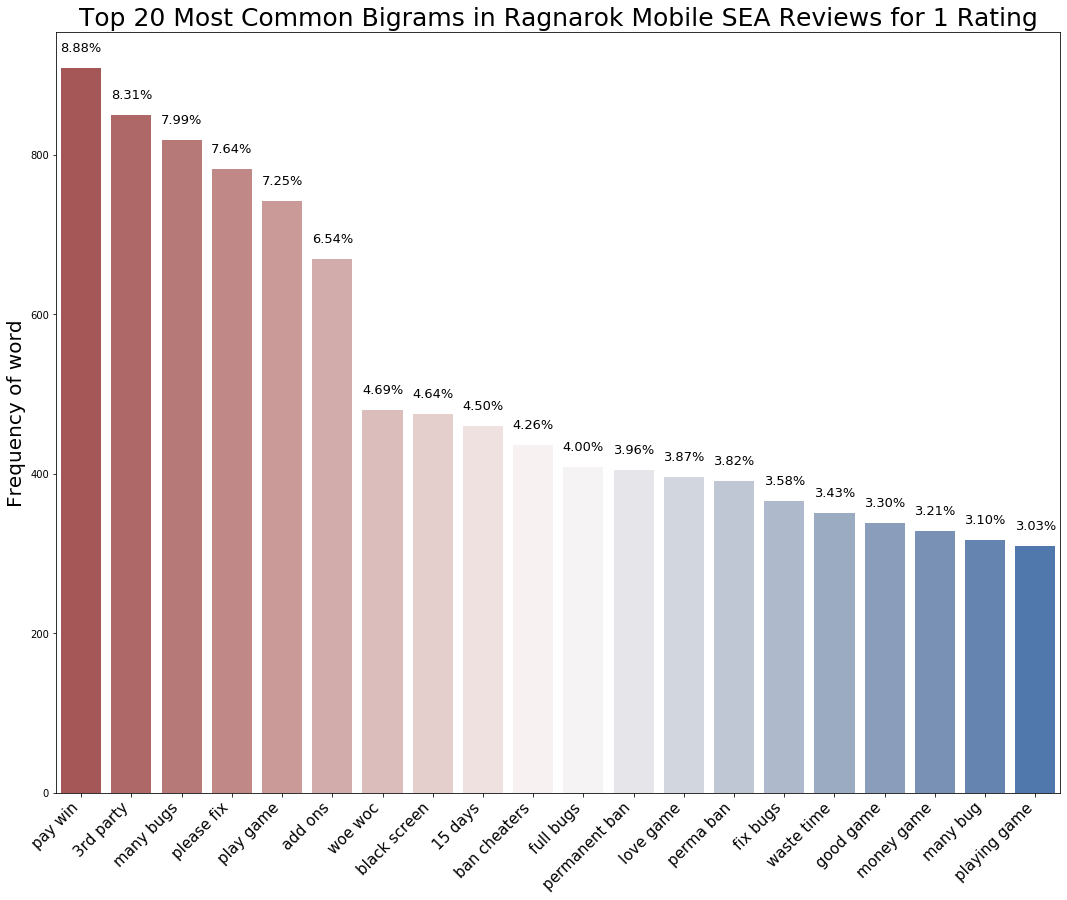

In [121]:
mostcommonwords201bisea = bigram1sea[:20]

yaxis201bisea = [val[1] for val in mostcommonwords201bisea]

xaxis201bisea = [val[0] for val in mostcommonwords201bisea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis201bisea, yaxis201bisea, palette ="vlag_r")
plt.title('Top 20 Most Common Bigrams in Ragnarok Mobile SEA Reviews for 1 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis201bisea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [122]:
trigram1sea = n_gramall(rating1sea['content'], n=3)
trigram1sea[:20]

[('pay win game', 219),
 ('3rd party app', 176),
 ('stuck loading screen', 161),
 ('using 3rd party', 150),
 ('lagnarok eternal bug', 142),
 ('3rd party program', 135),
 ('15 days ban', 114),
 ('3rd party apps', 113),
 ('bugnarok eternal lag', 106),
 ('game full bugs', 105),
 ('perma ban cheaters', 99),
 ('ban add users', 93),
 ('15 days suspension', 87),
 ('waste time money', 82),
 ('permanent ban cheaters', 81),
 ('use 3rd party', 81),
 ('dont play game', 80),
 ('bug bug bug', 79),
 ('using add ons', 76),
 ('game pay win', 72)]

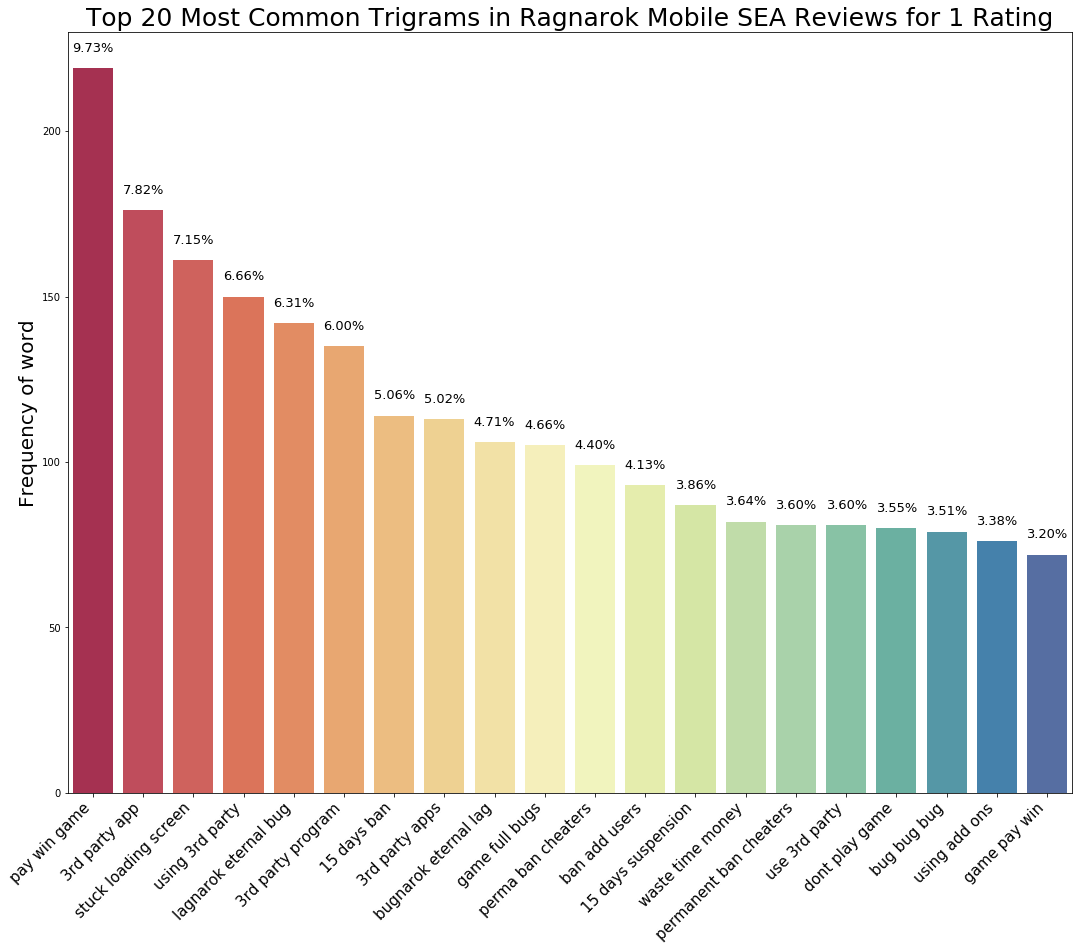

In [123]:
mostcommonwords201trisea = trigram1sea[:20]

yaxis201trisea = [val[1] for val in mostcommonwords201trisea]

xaxis201trisea = [val[0] for val in mostcommonwords201trisea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis201trisea, yaxis201trisea, palette ="Spectral")
plt.title('Top 20 Most Common Trigrams in Ragnarok Mobile SEA Reviews for 1 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis201trisea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [124]:
# Rating 2

bigram2sea = n_gramall(rating2sea['content'], n=2)
bigram2sea[:20]

[('please fix', 227),
 ('play game', 94),
 ('loading screen', 91),
 ('black screen', 87),
 ('stuck loading', 82),
 ('pay win', 55),
 ('love game', 53),
 ('good game', 50),
 ('cant login', 49),
 ('please help', 47),
 ('great game', 44),
 ('pls fix', 44),
 ('cant play', 42),
 ('game good', 42),
 ('many bugs', 38),
 ('cant log', 37),
 ('fix problem', 34),
 ('playing game', 34),
 ('start game', 33),
 ('cant download', 30)]

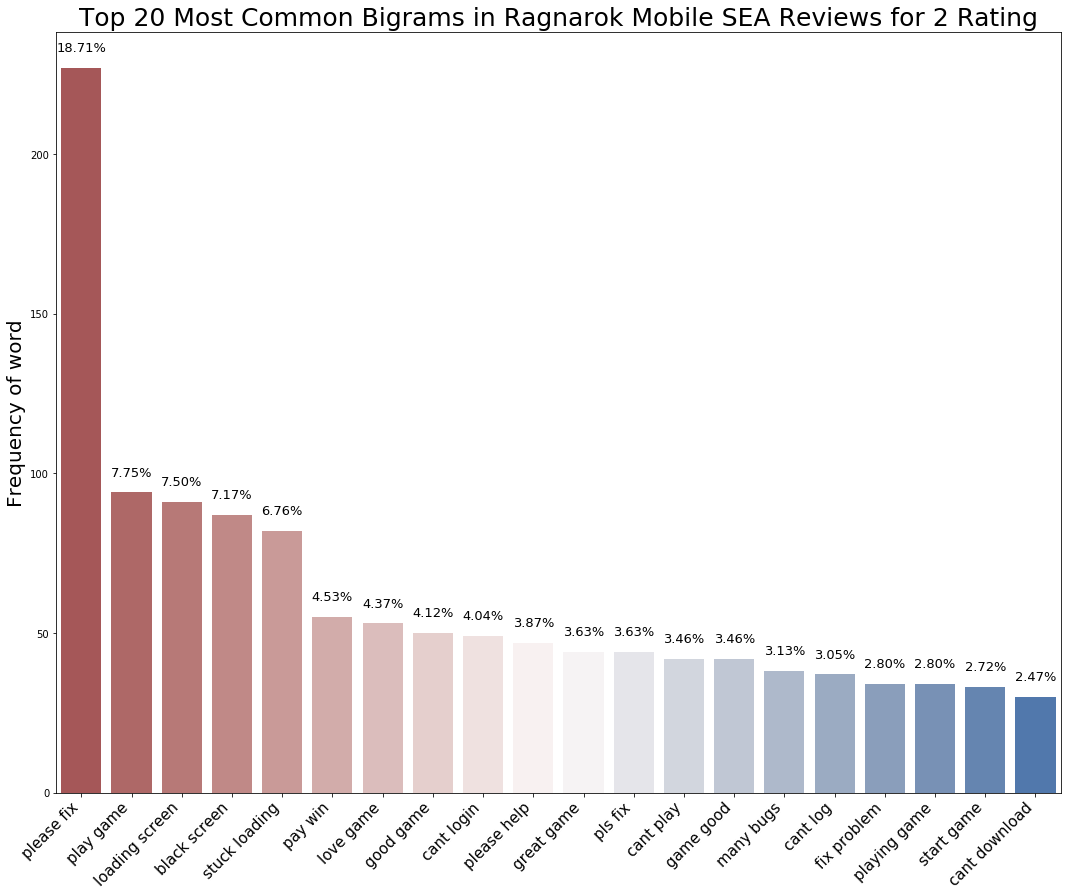

In [125]:
mostcommonwords202bisea = bigram2sea[:20]

yaxis202bisea = [val[1] for val in mostcommonwords202bisea]

xaxis202bisea = [val[0] for val in mostcommonwords202bisea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis202bisea, yaxis202bisea, palette ="vlag_r")
plt.title('Top 20 Most Common Bigrams in Ragnarok Mobile SEA Reviews for 2 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis202bisea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [126]:
trigram2sea = n_gramall(rating2sea['content'], n=3)
trigram2sea[:20]

[('stuck loading screen', 54),
 ('please fix bug', 16),
 ('please fix problem', 14),
 ('stuck login screen', 14),
 ('cant login game', 13),
 ('stuck black screen', 11),
 ('im stuck loading', 10)]

In [127]:
# Rating 3

bigram3sea = n_gramall(rating3sea['content'], n=2)
bigram3sea[:20]

[('please fix', 297),
 ('loading screen', 141),
 ('good game', 125),
 ('stuck loading', 125),
 ('play game', 114),
 ('love game', 99),
 ('please help', 98),
 ('black screen', 86),
 ('cant log', 75),
 ('game good', 69),
 ('great game', 61),
 ('cant login', 58),
 ('pls fix', 53),
 ('nice game', 50),
 ('enter game', 48),
 ('fix bug', 48),
 ('pay win', 46),
 ('start game', 46),
 ('many bugs', 45),
 ('im using', 44)]

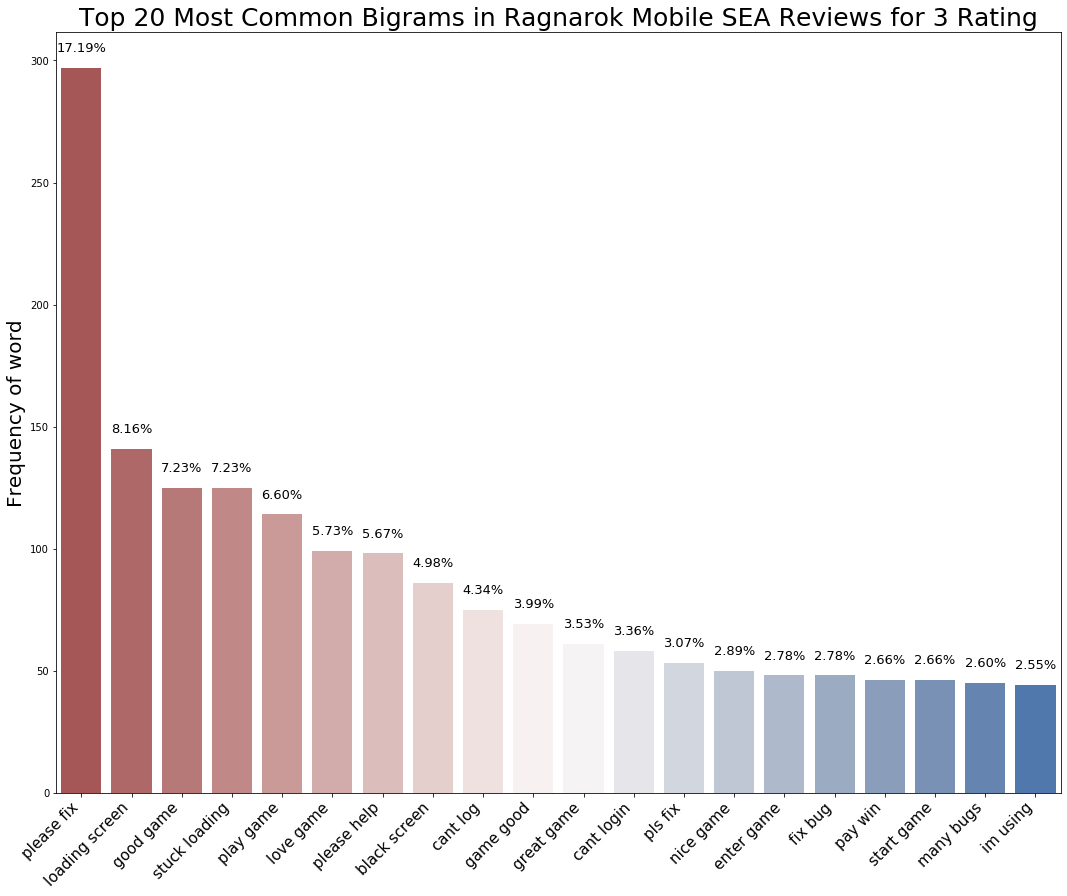

In [128]:
mostcommonwords203bisea = bigram3sea[:20]

yaxis203bisea = [val[1] for val in mostcommonwords203bisea]

xaxis203bisea = [val[0] for val in mostcommonwords203bisea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis203bisea, yaxis203bisea, palette ="vlag_r")
plt.title('Top 20 Most Common Bigrams in Ragnarok Mobile SEA Reviews for 3 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis203bisea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [129]:
trigram3sea = n_gramall(rating3sea['content'], n=3)
trigram3sea[:20]

[('stuck loading screen', 82),
 ('please fix bug', 22),
 ('game please fix', 19),
 ('please fix asap', 19),
 ('big cat coin', 17),
 ('please fix thanks', 17),
 ('game stuck loading', 16),
 ('stuck loading page', 16),
 ('cant enter game', 15),
 ('cant play game', 15),
 ('screen please fix', 14),
 ('always stuck loading', 13),
 ('want play game', 13),
 ('stuck login screen', 12),
 ('touch start game', 12),
 ('cant login game', 11),
 ('please fix issue', 11),
 ('please help fix', 11),
 ('really love game', 11),
 ('im stuck loading', 10)]

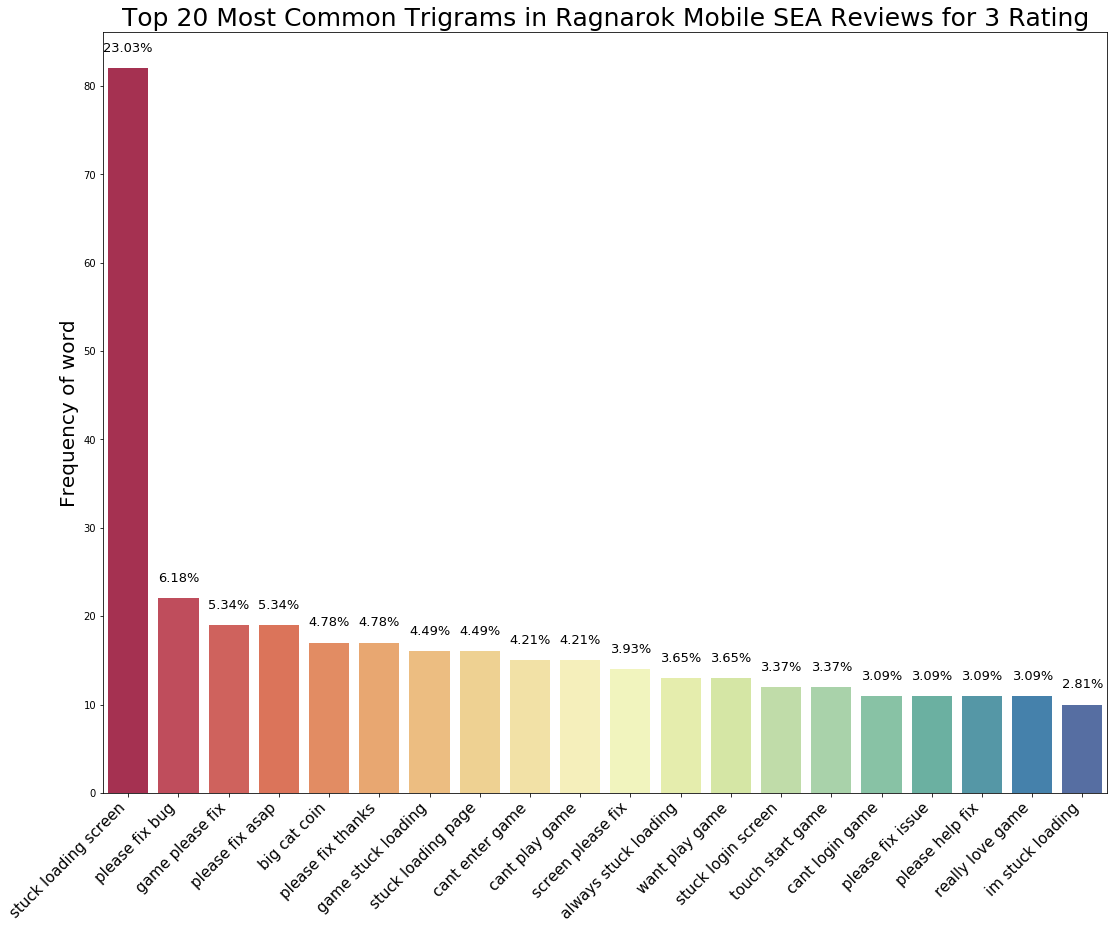

In [130]:
mostcommonwords203trisea = trigram3sea[:20]

yaxis203trisea = [val[1] for val in mostcommonwords203trisea]

xaxis203trisea = [val[0] for val in mostcommonwords203trisea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis203trisea, yaxis203trisea, palette ="Spectral")
plt.title('Top 20 Most Common Trigrams in Ragnarok Mobile SEA Reviews for 3 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis203trisea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [131]:
# Rating 4

bigram4sea = n_gramall(rating4sea['content'], n=2)
bigram4sea[:20]

[('good game', 254),
 ('please fix', 201),
 ('nice game', 180),
 ('great game', 170),
 ('love game', 124),
 ('play game', 83),
 ('loading screen', 76),
 ('game good', 72),
 ('stuck loading', 71),
 ('please help', 64),
 ('fix bugs', 50),
 ('far good', 49),
 ('like game', 49),
 ('brings back', 47),
 ('good job', 43),
 ('pls fix', 40),
 ('cant play', 39),
 ('game great', 39),
 ('black screen', 38),
 ('fix bug', 38)]

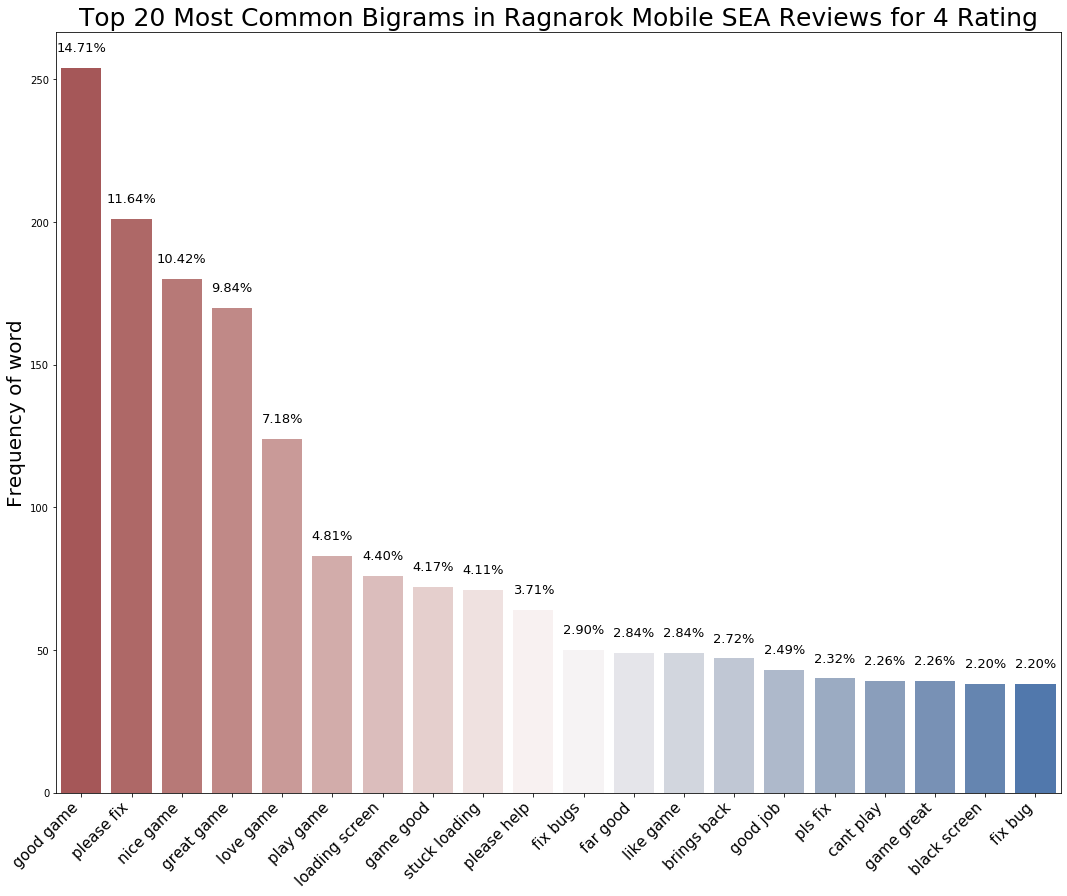

In [132]:
mostcommonwords204bisea = bigram4sea[:20]

yaxis204bisea = [val[1] for val in mostcommonwords204bisea]

xaxis204bisea = [val[0] for val in mostcommonwords204bisea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis204bisea, yaxis204bisea, palette ="vlag_r")
plt.title('Top 20 Most Common Bigrams in Ragnarok Mobile SEA Reviews for 4 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis204bisea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [133]:
trigram4sea = n_gramall(rating4sea['content'], n=3)
trigram4sea[:20]

[('stuck loading screen', 52),
 ('keep good work', 25),
 ('brings back memories', 23),
 ('please fix bug', 16),
 ('game brings back', 15),
 ('please fix bugs', 15),
 ('best game ever', 14),
 ('love game much', 13),
 ('really love game', 13),
 ('game please fix', 10),
 ('pay win game', 10),
 ('screen please fix', 10)]

In [134]:
# Rating 5

bigram5sea = n_gramall(rating5sea['content'], n=2)
bigram5sea[:20]

[('nice game', 1852),
 ('good game', 1632),
 ('great game', 1196),
 ('love game', 991),
 ('best game', 802),
 ('game ever', 653),
 ('brings back', 366),
 ('bring back', 302),
 ('good job', 291),
 ('please fix', 285),
 ('play game', 280),
 ('back memories', 278),
 ('awesome game', 271),
 ('best mmorpg', 257),
 ('game good', 195),
 ('back old', 188),
 ('game love', 176),
 ('like game', 175),
 ('playing game', 149),
 ('keep good', 146)]

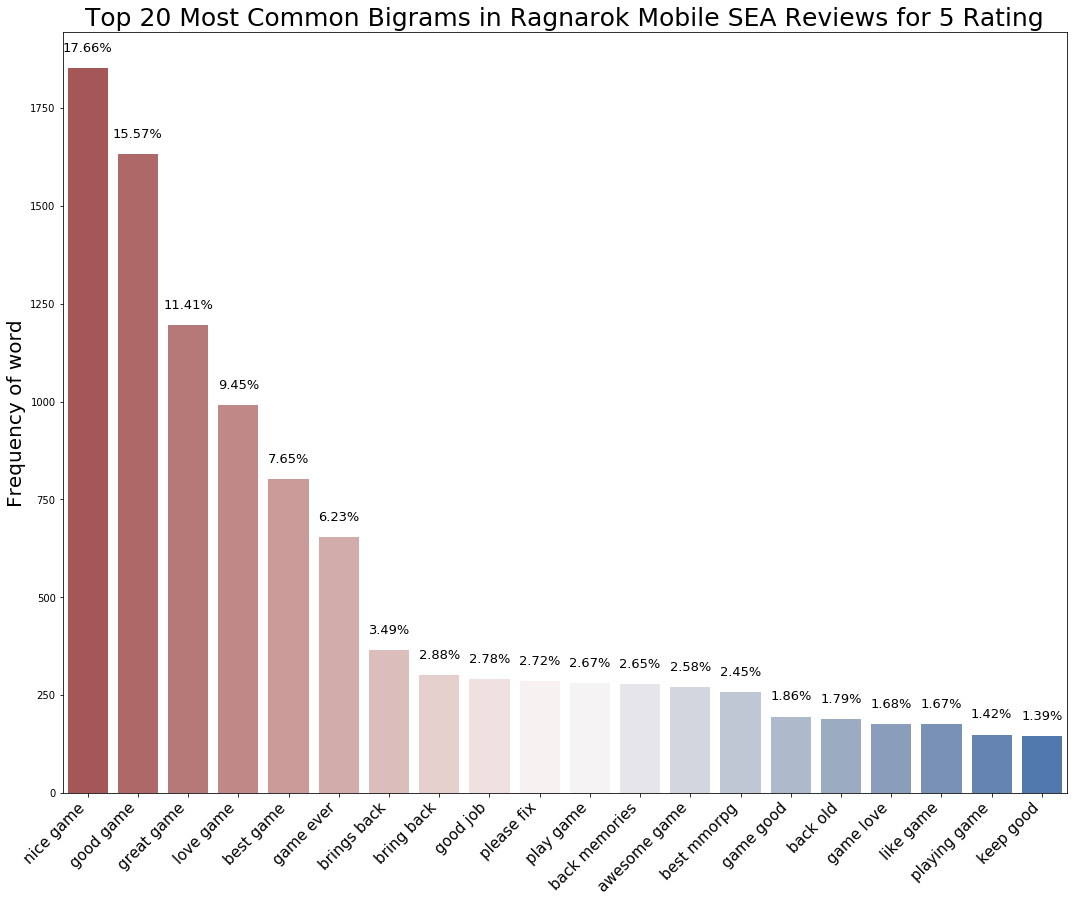

In [135]:
mostcommonwords205bisea = bigram5sea[:20]

yaxis205bisea = [val[1] for val in mostcommonwords205bisea]

xaxis205bisea = [val[0] for val in mostcommonwords205bisea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis205bisea, yaxis205bisea, palette ="vlag_r")
plt.title('Top 20 Most Common Bigrams in Ragnarok Mobile SEA Reviews for 5 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis205bisea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [136]:
trigram5sea = n_gramall(rating5sea['content'], n=3)
trigram5sea[:20]

[('best game ever', 413),
 ('brings back memories', 155),
 ('keep good work', 128),
 ('bring back memories', 104),
 ('love game much', 81),
 ('bring back old', 77),
 ('game brings back', 77),
 ('back old memories', 76),
 ('really love game', 76),
 ('brings back old', 60),
 ('game bring back', 56),
 ('stuck loading screen', 49),
 ('good old days', 47),
 ('best mobile game', 46),
 ('game ever played', 43),
 ('brings back childhood', 41),
 ('best mmorpg mobile', 38),
 ('like old times', 38),
 ('nice game love', 37),
 ('best mmorpg ever', 36)]

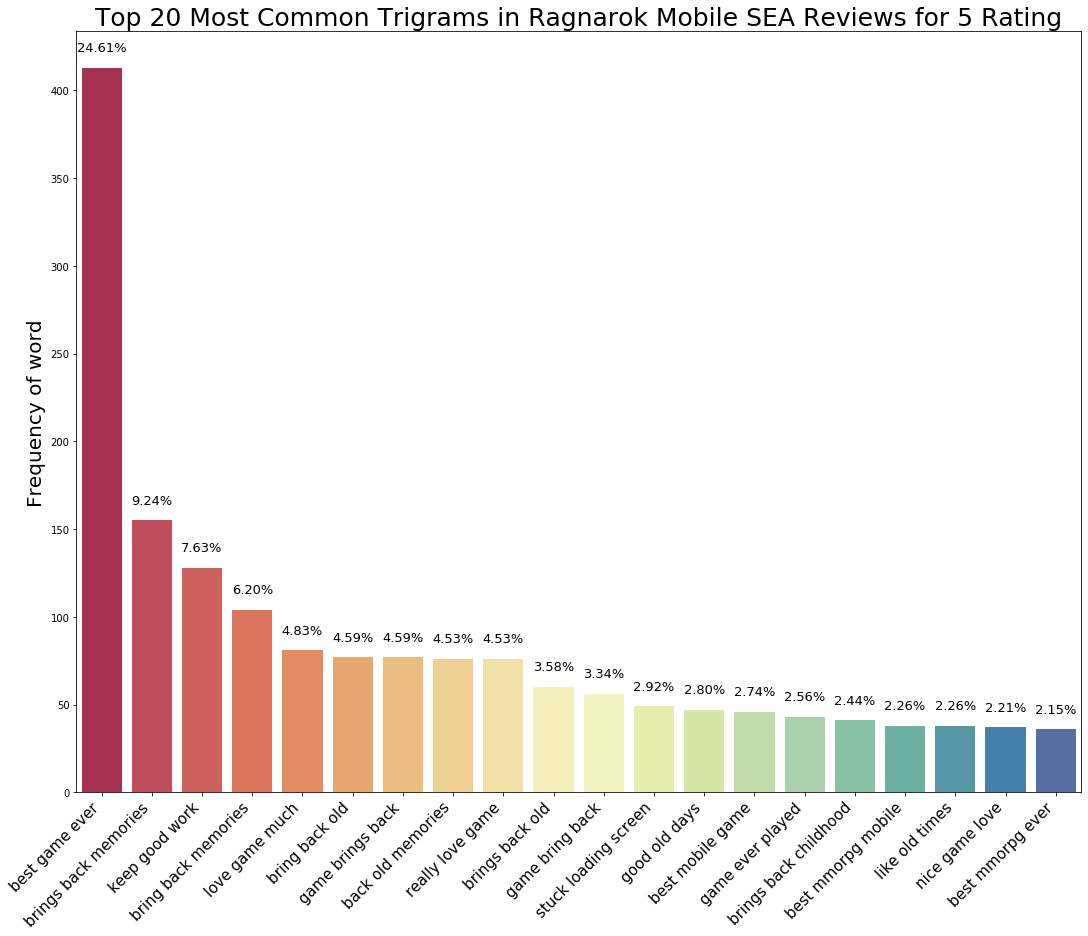

In [137]:
mostcommonwords205trisea = trigram5sea[:20]

yaxis205trisea = [val[1] for val in mostcommonwords205trisea]

xaxis205trisea = [val[0] for val in mostcommonwords205trisea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis205trisea, yaxis205trisea, palette ="Spectral")
plt.title('Top 20 Most Common Trigrams in Ragnarok Mobile SEA Reviews for 5 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis205trisea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')